# **<center>Facial Emotion Classification</center>**

### **Library Loading**

In [1]:
import numpy as np
#%watermark -p numpy
import pandas as pd
#%watermark -p pandas
import matplotlib.pyplot as plt
#%matplotlib inline 
#%watermark -p matplotlib
plt.rcParams['font.size'] = '16'
import seaborn as sns
#%watermark -p seaborn


import os # For reading the dataset
import cv2 # For Reading the images
#%watermark -p cv2


import torch
import torch.nn as nn
#%watermark -p torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torchvision
#%watermark -p torchvision
from torchvision import datasets, models, transforms , utils


from timeit import default_timer as timer

# Table of Contents

* [1. Problem Statement:](#h1)

* [2. Data Source and Description](#h2)
    * [2.1 Data Source](#h2_1)
    * [2.2 Data Description](#h2_2)
    * [2.3 EDA](#h2_3)
      * [2.3.1 Number of Imager Per Sample Classes](#h2_3_1)
      * [2.3.2 spliting the data into train and validation sets](#h2_3_2)
      * [2.3.3 Visulise random image example of each category](#h2_3_3)
           * [2.3.3.a Example of Training Data](#h2_3_3a)
           * [2.3.3.b Example of Validation Data](#h2_3_3b)


* [3. Report](#h3)

    * [Section 1.1](#section_1_1)
    * [Section 1.2](sSection_1_2)
      * [Section 1.2.1](#section_1_2_1)
      * [Section 1.2.2](#section_1_2_2)
      * [Section 1.2.3](#section_1_2_3)
 
 
* [4. Data Preprocessing](#h4)
    * [4.1 Creating a Class for data preprocesing](#h4_1)
    * [4.2 Data Augmentation](#h4_2)
         * [4.2.1 A quick look after Augmentation](#h4_2_1)
  
  
* [5. Model Building](#h5)
    * [5.1 Definning Data Loader](#h5_1)
    * [5.3 Definning Loss Function](#h5_2)
    * [5.3 Definning Model](#h5_3)
    * [5.4 Loading Model](#h5_4)
      * [5.4.1 Freeze training for all "features" layers](#h5_4_1)
      * [5.4.2 Training the fullyconnected layers](#h5_4_2)
          * [5.4.2.a Implementing SGD with learning rate 0.001](#h5_4_2a)
              * [Loss and Accuracy curve for SGD with leaining rate 0.001](#h5_4_2_ap)
          * [5.4.2.b Accuracy using SGD with learning rate 0.001](#h5_4_2b)
          * [5.4.3 Training SGD with learning rate 0.05](#h5_4_3)
              * [Loss and Accuracy plot for SGD with learning rate 0.05](#h5_4_3p)
          * [5.4.3.b Accuracy using SGD with learning rate 0.05](#h5_4_3b)
          * [5.4.4 Implementing ADAM with learning rate 0.001](#h5_4_4)
              * [Loss and Accuracy curve for ADAM with leaining rate 0.001](#h5_4_4p)
          * [5.4.4.b Accuracy using ADAM with learning rate 0.001](#h5_4_4b) 
          * [5.4.5 Implementing ADAM with learning rate 0.05](#h5_4_5)
              * [Loss and Accuracy curve for ADAM with leaining rate 0.05](#h5_4_5p)
          * [5.4.6 Implementing RMSprop with learning rate 0.001](#h5_4_6)
              * [Loss and Accuracy curve for RMSprop with learning rate 0.001](#h5_4_6p)
          * [5.4.4.b Accuracy using ADAM with learning rate 0.001](#h5_4_6b)
          * [5.4.7 Implementing RMSprop with learning rate 0.05](#h5_4_7)
              * [Loss and Accuracy curve for RMSprop with learning rate 0.05](#h5_4_7p)
          * [5.4.7.b Accuracy using RMSprop with learning rate 0.001](#h5_4_7b)

 
 * [6. Results:](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)

# 1. Problem Statement: <a class="anchor" id="h1"></a>

### Challenge Description:

Social media platforms are widely used by individuals and organizations to express emotions, opinions, and ideas. These platforms generate vast amounts of data, which can be analyzed to gain insights into user behavior, preferences, and sentiment. Accurately classifying the sentiment of social media posts can provide valuable insights for businesses, individuals, and organizations to make informed decisions.

To accomplish this task, a customized private cartoon dataset (original images) of social media posts has been provided, which contains labels for each post's emotion category, such as happy, angry, sad, or neutral.

The task is to build and fine-tune a machine-learning model that accurately classifies social media posts into their corresponding emotion categories, using synthetic images.

# 2. Data Source and Description <a class="anchor" id="h2"></a>

## 2.1 Data Source: <a class="anchor" id="h2_1"></a>

This Dataset has been collected from [kaggle](https://www.kaggle.com/datasets/revelation2k23/brain-dead-emotion-detection)

## 2.2 Data Description: <a class="anchor" id="h2_2"></a>

Ref: https://www.kaggle.com/datasets/revelation2k23/brain-dead-emotion-detection

This dataset contains 2179 png images of cartoons classified into 4 classes: 'angry', 'happy', 'neutral' and 'sad'.


We have used StyleGAN to upsample each image classes in the final training dataset.

## 2.3 EDA <a class="anchor" id="h2_3"></a>

In [12]:
# Path for the training data
path = '/home/sysadm/Desktop/Ujjwal/'

In [13]:
classes = ['angry', 'happy', 'neutral', 'sad']

## 2.3.1 Number of Imager Per Sample Classes <a class="anchor" id="h2_3_1"></a>

In [14]:
# Creating a function to count the number of files inside each folders of the directory
def data_count(path):
    counts = {}
    for root,dirs,files in os.walk(path):
        if files != [] and str(root.split('/')[-1]) in classes:
            counts[str(root.split('/')[-1])] = len(files)
    return counts

counts = data_count(path)

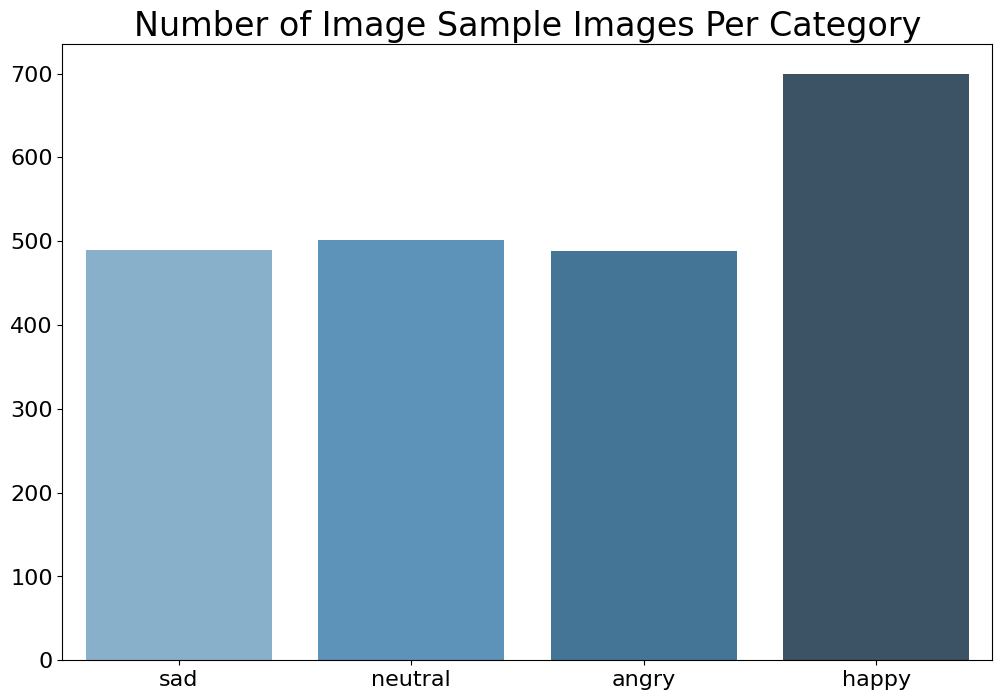

In [15]:

# Plot number of files per category
plt.figure(figsize=(12,8))

plt.title('Number of Image Sample Images Per Category', 
          fontsize=24)

sns.barplot(x = list(counts.keys()),
            y = list(counts.values()) , 
            palette="Blues_d" )

plt.show()

We have lots of images per category, so we can split it into train and validation in 70:30 ratio.

## 2.3.2 spliting the data into train and validation sets <a class="anchor" id="h2_3_2"></a>

In [16]:
def data_split(path, split_percentage = 0.3):
    train_dict = {} # Dictionary to store training data
    valid_dict = {} # Dictionary to store validation data
    counts = data_count(path)
    for root,dirs,files in os.walk(path):
        if files != [] and str(root.split('/')[-1]) in classes:
            file_paths = [os.path.join(root,files[i]) for i in range(len(files))]
            
            valid_idxs = np.random.randint(low=0,high=len(files),size=int(len(files)*split_percentage))
            train_idxs = list(set(range(0,len(files))) - set(valid_idxs))
            
            train_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in train_idxs]
            valid_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in valid_idxs]
            
    return train_dict, valid_dict

train_dict, valid_dict = data_split(path) 

In [17]:
print('training data sizes : ', [len(l) for l in train_dict.values()])
print('validation data sizes : ', [len(l) for l in valid_dict.values()])

training data sizes :  [360, 367, 363, 522]
validation data sizes :  [147, 150, 146, 210]


## 2.3.3 Visulise random image example of each category <a class="anchor" id="h2_3_3"></a>

In [3]:
# Function to plot random image example
def visualize(data_dict):    
    idx = np.random.randint(0,min(list([len(l) for l in data_dict.values()])))

    plt.figure(figsize=(30,6))
    plt.subplot(161)
    plt.imshow(cv2.imread(train_dict['angry'][idx]).astype(int))
    plt.title('angry')
    plt.subplot(162)
    plt.imshow(cv2.imread(train_dict['happy'][idx]).astype(int))
    plt.title('happy')
    plt.subplot(163)
    plt.imshow(cv2.imread(train_dict['neutral'][idx]).astype(int))
    plt.title('neutral')
    plt.subplot(164)
    plt.imshow(cv2.imread(train_dict['sad'][idx]).astype(int))
    plt.title('sad')

    plt.show()

### 2.3.3.a Example of Training Data <a class="anchor" id="h2_3_3a"></a>

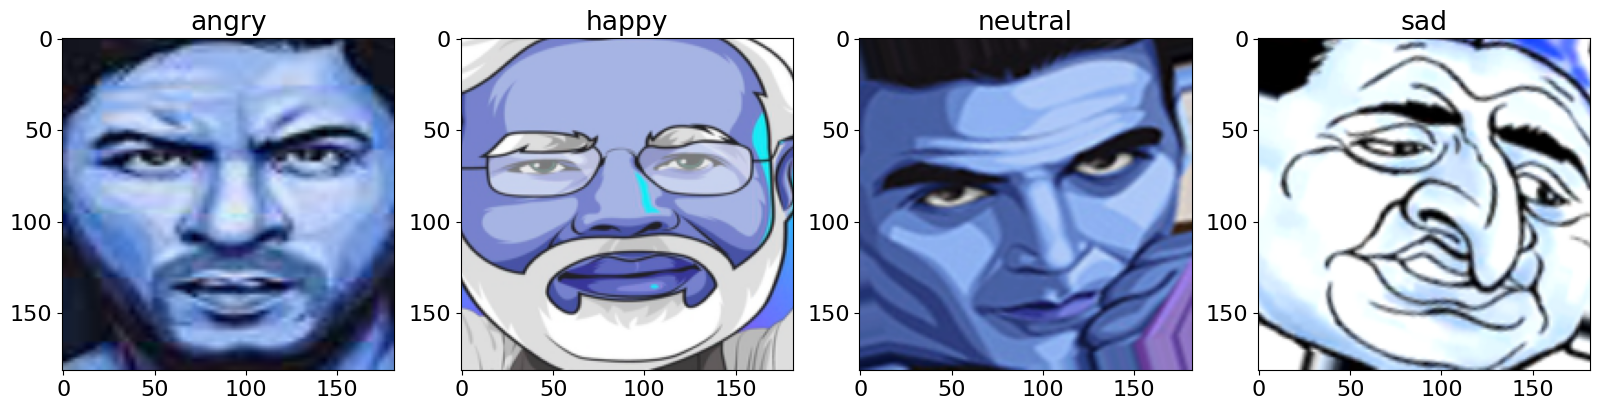

In [20]:
visualize(train_dict)

### 2.3.3.b Example of Validation Data <a class="anchor" id="h2_3_3b"></a>

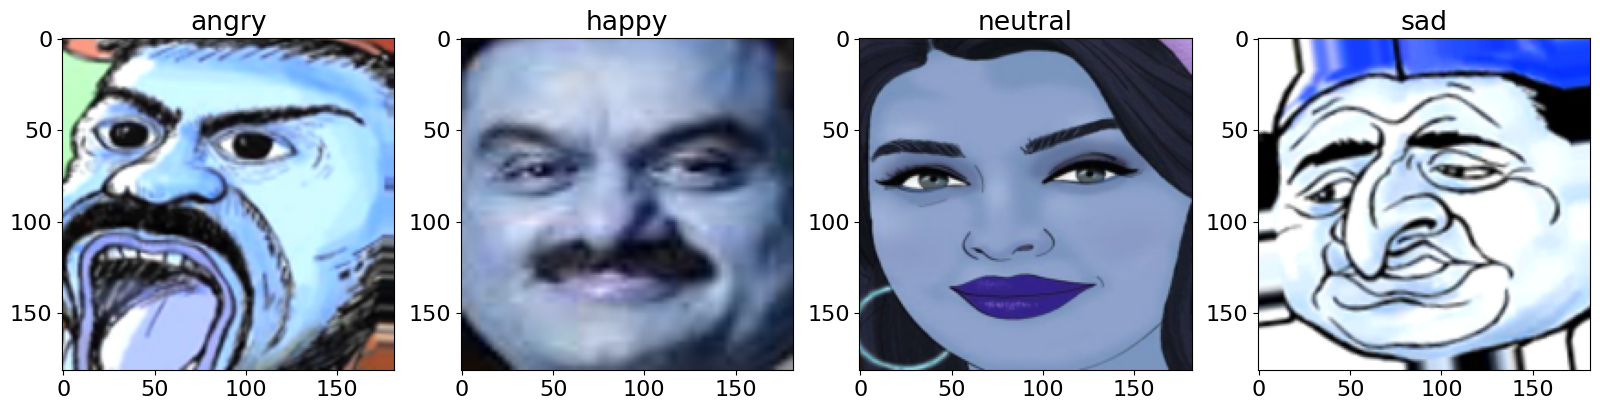

In [21]:
visualize(valid_dict)

# 3. Report <a class="anchor" id="h3"></a>

# 4. Data Preprocessing <a class="anchor" id="h4"></a>

## 4.1 Creating a Class for data preprocesing <a class="anchor" id="h4_1"></a>

In [4]:
class RIData(Dataset):
    
    def __init__(self, data_dict, transform=None):
        """
        Args:
            data_dict (dict): dictionary with class as key and the corresponding paths to the data of that class 
        """
        self.data_dict = data_dict
        self.transform = transform
        
    def __len__(self):
        return sum([len(l) for l in self.data_dict.values()])
    
    def __getitem__(self,idx):
        counts = [len(l) for l in self.data_dict.values()]
        sum_counts = list(np.cumsum(counts))
        sum_counts = [0] + sum_counts + [np.inf]
        
        for c,v in enumerate(sum_counts):
            if idx < v:
                i = (idx - sum_counts[c-1]) - 1
                break

        label = list(self.data_dict.keys())[c-1]
        img = Image.open(self.data_dict[str(label)][i]).convert('RGB')
        if self.transform:
            img = self.transform(img)
            
        return img, classes.index(str(label))

## 4.2 Data Augmentation <a class="anchor" id="h4_2"></a>

Data augmentation is useful to improve performance and outcomes of machine learning models by forming new and different examples to train datasets. If the dataset in a machine learning model is rich and sufficient, the model performs better and more accurately.

![**Figure 1:** Data Augmentation](https://research.aimultiple.com/wp-content/uploads/2021/04/data-augmentation-techniques.png)
**Figure 1:** Data Augmentation Techniques [source](https://research.aimultiple.com/data-augmentation-techniques/)



Since our dataset is large enough for VGG16, we need not to apply so many data transformations. 
Simple Verticle flip, horizontal flip and some basic filter like colorJitter and some Sharpness enhancement will be enough

In [23]:
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ColorJitter(),
                                     transforms.Resize((224,224))])

data_train = RIData(train_dict,transform = data_transform)
data_valid = RIData(valid_dict,transform = data_transform)

print("Total Number of training images : ", len(data_train))
print("Total Number of validation images : ", len(data_valid))

Total Number of training images :  1612
Total Number of validation images :  653


### 4.2.1 A quick look after augmentation <a class="anchor" id="h4_2_1"></a>

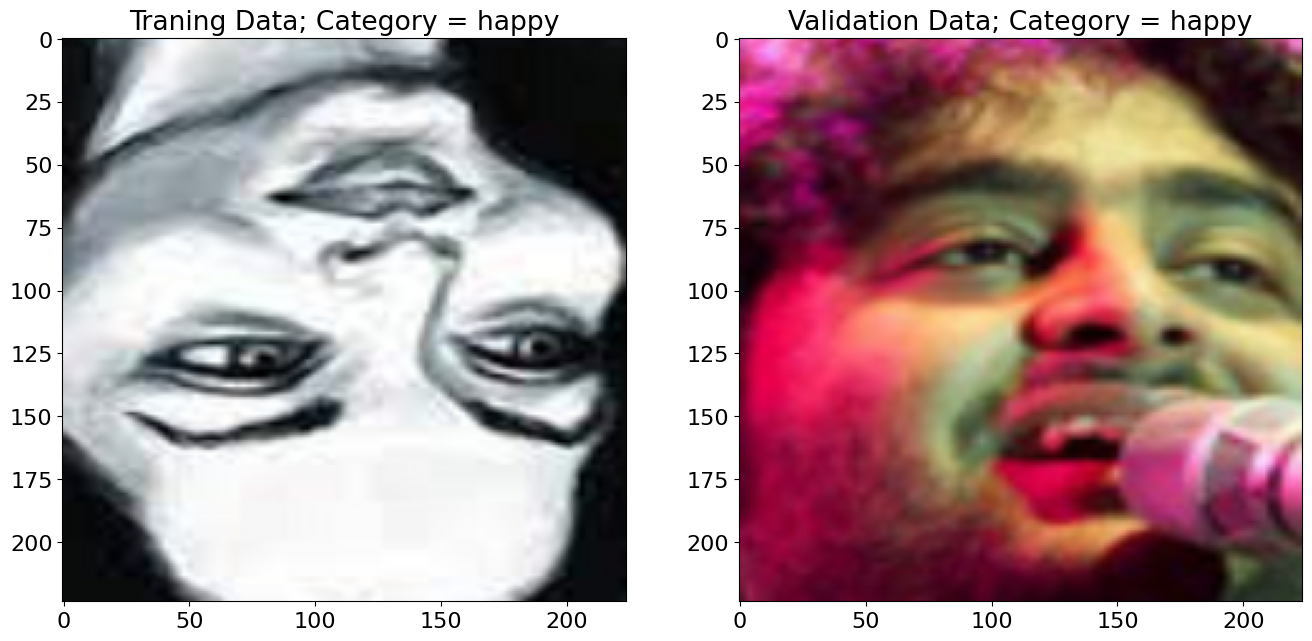

In [24]:
t_idx = np.random.randint(0,len(data_train))
v_idx = np.random.randint(0,len(data_valid))


t_img,t_label = data_train[t_idx]
v_img,v_label = data_valid[v_idx]

plt.figure(figsize=(16,9))
plt.subplot(121)
plt.imshow(t_img.numpy().transpose(1,2,0))
plt.title(f'Traning Data; Category = {classes[t_label]}')
plt.subplot(122)
plt.imshow(v_img.numpy().transpose(1,2,0))
plt.title(f'Validation Data; Category = {classes[v_label]}')
plt.show()

# 5. Model Building <a class="anchor" id="h5"></a>

## 5.1 Definning Data Loader <a class="anchor" id="h5_1"></a>

In [25]:
train_loader = DataLoader(data_train, batch_size=50, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=50, shuffle=True)

In [26]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched[0].size(),sample_batched[1])
    print(type(sample_batched[0]))
    break

0 torch.Size([50, 3, 224, 224]) tensor([2, 1, 3, 1, 2, 2, 1, 3, 3, 2, 3, 0, 3, 2, 0, 3, 1, 1, 1, 3, 2, 3, 1, 2,
        1, 2, 0, 1, 0, 2, 1, 0, 3, 2, 1, 0, 3, 2, 0, 1, 3, 0, 2, 1, 3, 3, 0, 1,
        1, 1])
<class 'torch.Tensor'>


## 5.2 Definning Loss Function <a class="anchor" id="h5_2"></a>

In [27]:
criterion = nn.CrossEntropyLoss()

## 5.3 Definning Model <a class="anchor" id="h5_3"></a>

The [VGG-16](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html) is able to classify 1000 different labels; we just need 4 instead. 
In order to do that we are going replace the last fully connected layer of the model with a new one with 4 output features instead of 1000. 


![**Figure 2:** VGG 16](https://miro.medium.com/max/1400/1*NNifzsJ7tD2kAfBXt3AzEg.png)

**Figure 2:** VGG 16 Architecture [source](https://medium.com/mlearning-ai/an-overview-of-vgg16-and-nin-models-96e4bf398484)

In PyTorch, we can access the VGG-16 classifier with `model.classifier`, which is an 6-layer array. We will replace the last entry.

We can also disable training for the convolutional layers setting `requre_grad = False`, as we will only train the fully connected classifier.

## 5.4 Loading Model <a class="anchor" id="h5_4"></a>

In [13]:
#Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features)

4096
1000


In [19]:
!nvidia-smi

Thu Mar 23 21:16:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:2D:00.0  On |                  Off |
| 41%   48C    P2    29W / 250W |  24082MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 5.4.1 Freeze training for all "features" layers <a class="anchor" id="h5_4_1"></a>

In [14]:
for param in vgg16.features.parameters():
    param.requires_grad = False

In [20]:
n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("training on gpu...")
    vgg16.cuda()
else:
    print("no gpu found.")

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
print(vgg16)

training on gpu...
4
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, 

### 5.4.2 Training the fullyconnected layers <a class="anchor" id="h5_4_2"></a>

In [21]:
def base_model_build():
    #Load the pretrained model from pytorch
    vgg16 = models.vgg16(pretrained=True)

    # print out the model structure
    #print(vgg16)
    
    # Freeze training for all "features" layers
    for param in vgg16.features.parameters():
        param.requires_grad = False
        
    import torch.nn as nn

    n_inputs = vgg16.classifier[6].in_features

    # add last linear layer (n_inputs -> 5 flower classes)
    # new layers automatically have requires_grad = True
    last_layer = nn.Linear(n_inputs, len(classes))

    vgg16.classifier[6] = last_layer

    # if GPU is available, move the model to GPU
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        print("training on gpu...")
        vgg16.cuda()
    else:
        print("no gpu found.")

    # check to see that your last layer produces the expected number of outputs
    #print(vgg16.classifier[6].out_features)
    #print(vgg16)
    
    return vgg16


def loss_acc_visuaize(history,optim,path):
    plt.figure(figsize=(20,10))

    plt.suptitle(str(optim))

    plt.subplot(121)
    plt.plot(history['train_loss'],label='train_loss')
    plt.plot(history['valid_loss'],label='valid_loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(122)
    plt.plot(history['train_acc'],label='train_acc')
    plt.plot(history['valid_acc'],label='valid_acc')
    plt.legend()
    plt.title('Accuracy Curves')
    
    plt.savefig(str(path) + 'loss_acc.png')




def visual_predict(model,data=data_valid):
    c = np.random.randint(0,len(data))
    img, label = data[c]

    with torch.no_grad():
            model.eval()
            # Model outputs log probabilities
            out = model(img.view(1,3,224,224).cuda())
            out = torch.exp(out)
            print(out)

    plt.figure(figsize = (10,5))
    plt.subplot(121)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.title(str(classes[label]))
    plt.subplot(122)
    plt.barh(classes,out.cpu().numpy()[0])

    plt.show()
    

def class_accuracies(model,data_dict=valid_dict,classes=classes):
    accuracy_dict = {}
    with torch.no_grad():
        model.eval()
        for c in data_dict.keys():
            correct_count = 0
            total_count = len(data_dict[str(c)])
            gt = classes.index(str(c))
            for path in data_dict[str(c)]:
                #print(path)
                im = Image.open(path).convert('RGB')
                #im.show()
                im = transforms.ToTensor()(im)
                im = transforms.Resize((224,224))(im)
                out = model(im.view(1,3,224,224).cuda())
                #print(out)
                out = torch.exp(out)
                pred = list(out.cpu().numpy()[0])
                #print(pred)
                pred = pred.index(max(pred))
                #print(pred,gt)

                if gt == pred:
                    correct_count += 1
            print(f"Accuracy for class {str(c)} : ",correct_count/total_count)
            accuracy_dict[str(c)] = correct_count/total_count
    return accuracy_dict

#### 5.4.2.a Implementing SGD with learning rate 0.001 <a class="anchor" id="h5_4_2a"></a>

### SGD (Stochastic Gradient Descent)

SGD is a optimizer used for fit the neural network, this technique is based by Gradient Descent.
In SGD is used the matriz representation, the equation for represent the update the weights is bellow.

$$ V_{k+1} = V_k - \eta . \nabla L(W_{ij}) $$
<br/>
$$  W = V_{k+1}  $$

Where the **η** is the step size, and the **∇L(W)** is the gradient of the Loss.

The gradient can be solved using the chain rule of the derivate the Loss funtion by Weights. The equation for output layer is bellow.

$$ \nabla L(W_{ij}) = \dfrac{dL(W_{ij})}{dW_{ij}} $$
<br/>
$$ =\dfrac{dL(t|y)}{dy}.\dfrac{dy}{dZ}.\dfrac{dZ}{dW_{ij}} $$
<br/>
$$ =\dfrac{1}{N} . \dfrac{(t-y)}{y.(1-y)}.y.(1-y). X_{ij} $$
<br/>
$$ = \dfrac{1}{N} . (t-y)X_{ij} $$
<br/>
<center>For the hidden layer:</center>
<br/>
$$ \nabla L(W_{ij}) = \dfrac{dL(W_{ij})}{dW_{ij}} $$
<br/>
$$ =\dfrac{dL(t|y_{ij})}{dy_{ij}}.\dfrac{dy_{ij}}{dZ_{ij}}.\dfrac{dZ_{ij}}{dy_{ij}}.\dfrac{dy_{ij}}{dZ_{ij}}.\dfrac{dZ_{ij}}{dW_{ij}} $$
<br/>
$$ = \dfrac{1}{N} . \dfrac{(t-y)}{y.(1-y)}.y.(1-y). W_{ij}.\sigma(x)'.X_{ij} $$
<br/>
$$ = \dfrac{1}{N} . (t-y).W_{ij}.\sigma(x)'.X_{ij} $$
<br/>

In [33]:
vgg16=base_model_build()
optimizer_sgd = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

model=vgg16
criterion=criterion
optimizer=optimizer_sgd
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-sgd-lr=0.001'
max_epochs_stop=50
n_epochs=80
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 18.27 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.3886 	Validation Loss: 1.2952
		Training Accuracy: 31.51%	 Validation Accuracy: 40.43%
Epoch: 1	100.00% complete. 17.81 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.2863 	Validation Loss: 1.2590
		Training Accuracy: 40.20%	 Validation Accuracy: 42.27%
Epoch: 2	100.00% complete. 17.96 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.2388 	Validation Loss: 1.2223
		Training Accuracy: 42.87%	 Validation Accuracy: 44.56%
Epoch: 3	100.00% complete. 17.98 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.2098 	Validation Loss: 1.1947
		Training Accuracy: 44.73%	 Validation Accuracy: 48.39%
Epoch: 4	100.00% complete. 17.98 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.1696 	Validation Loss: 1.1652
		Training Accuracy: 47.95%	 Validation Accuracy: 50.84%
Epoch: 5	100.00% complete. 18.19 seconds elapsed in epoch.
Epoch: 5 	Training Loss:

Epoch: 47	100.00% complete. 17.83 seconds elapsed in epoch.
Epoch: 47 	Training Loss: 0.8255 	Validation Loss: 0.9019
		Training Accuracy: 65.38%	 Validation Accuracy: 62.17%
Epoch: 48	100.00% complete. 17.68 seconds elapsed in epoch.
Epoch: 48 	Training Loss: 0.8036 	Validation Loss: 0.9064
		Training Accuracy: 65.45%	 Validation Accuracy: 60.64%
Epoch: 49	100.00% complete. 17.69 seconds elapsed in epoch.
Epoch: 49 	Training Loss: 0.8119 	Validation Loss: 0.9074
		Training Accuracy: 66.00%	 Validation Accuracy: 60.49%
Epoch: 50	100.00% complete. 17.60 seconds elapsed in epoch.
Epoch: 50 	Training Loss: 0.8003 	Validation Loss: 0.8997
		Training Accuracy: 66.69%	 Validation Accuracy: 60.49%
Epoch: 51	100.00% complete. 17.78 seconds elapsed in epoch.
Epoch: 51 	Training Loss: 0.7958 	Validation Loss: 0.8905
		Training Accuracy: 67.93%	 Validation Accuracy: 60.34%
Epoch: 52	100.00% complete. 17.68 seconds elapsed in epoch.
Epoch: 52 	Training Loss: 0.7878 	Validation Loss: 0.8968
		Train

## Loss and Accuracy curve for SGD with leaining rate 0.001 <a class="anchor" id="h5_4_2_ap"></a>

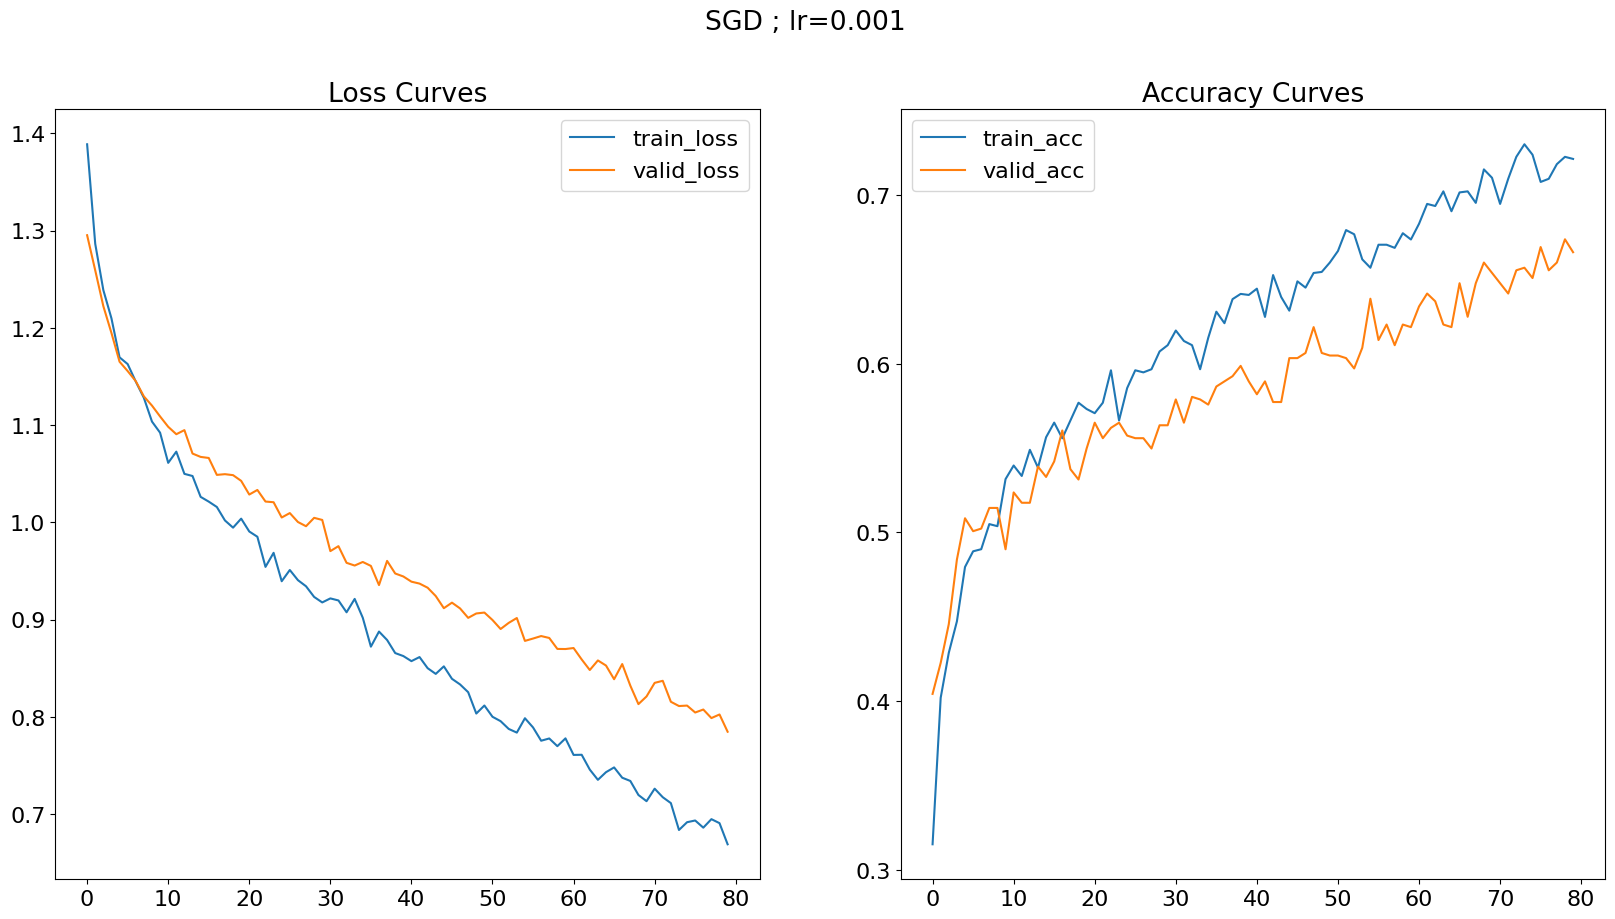

In [34]:
loss_acc_visuaize(history,optim='SGD ; lr=0.001',path='../')

In [35]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-sgd-lr=0.001"))

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...


<All keys matched successfully>

tensor([[4.0487, 0.9950, 0.6780, 0.5788]], device='cuda:0')


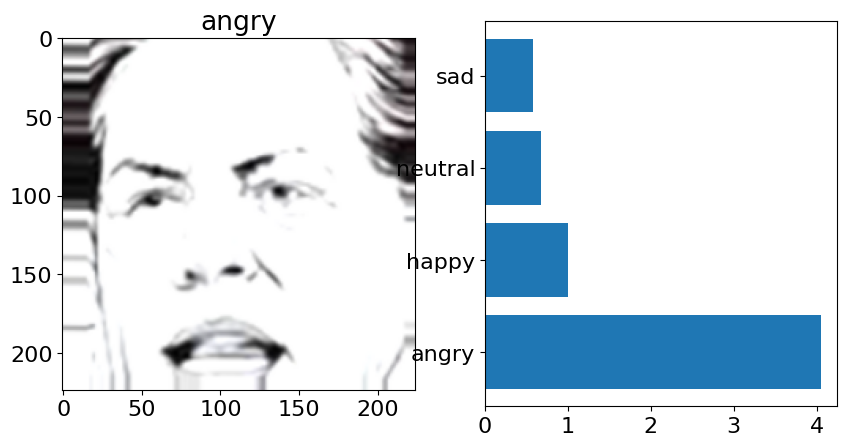

In [36]:
visual_predict(model=model)

### 5.4.2.b Accuracy using SGD with learning rate 0.001 <a class="anchor" id="h5_4_2b"></a>

In [37]:
sgd_lr001_dict = class_accuracies(model=model)

Accuracy for class sad :  0.7891156462585034
Accuracy for class neutral :  0.36666666666666664
Accuracy for class angry :  0.7397260273972602
Accuracy for class happy :  0.6761904761904762


### 5.4.3 Training SGD with learning rate 0.05 <a class="anchor" id="h5_4_3"></a>

In [38]:
# SGD with high learning rate

vgg16 = base_model_build()
optimizer_sgd = optim.SGD(vgg16.classifier.parameters(), lr=0.05)

model=vgg16
criterion=criterion
optimizer=optimizer_sgd
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-sgd-lr=0.05'
max_epochs_stop=50
n_epochs=80
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 17.82 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.3315 	Validation Loss: 1.0697
		Training Accuracy: 43.98%	 Validation Accuracy: 52.37%
Epoch: 1	100.00% complete. 17.87 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.9537 	Validation Loss: 1.0203
		Training Accuracy: 58.13%	 Validation Accuracy: 52.83%
Epoch: 2	100.00% complete. 17.95 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.8113 	Validation Loss: 1.0567
		Training Accuracy: 66.00%	 Validation Accuracy: 58.81%
Epoch: 3	100.00% complete. 18.02 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.7141 	Validation Loss: 0.9586
		Training Accuracy: 70.72%	 Validation Accuracy: 59.88%
Epoch: 4	100.00% complete. 18.04 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.6227 	Validation Loss: 0.8010
		Training Accuracy: 73.88%	 Validation Accuracy: 70.14%
Epoch: 5	100.00% complete. 18.05 seconds elapsed in epoch.
Epoch: 5 	Training Loss:

Epoch: 47	100.00% complete. 18.13 seconds elapsed in epoch.
Epoch: 47 	Training Loss: 0.0466 	Validation Loss: 0.7615
		Training Accuracy: 98.39%	 Validation Accuracy: 81.16%
Epoch: 48	100.00% complete. 18.16 seconds elapsed in epoch.
Epoch: 48 	Training Loss: 0.0421 	Validation Loss: 0.8906
		Training Accuracy: 98.64%	 Validation Accuracy: 76.26%
Epoch: 49	100.00% complete. 18.02 seconds elapsed in epoch.
Epoch: 49 	Training Loss: 0.0508 	Validation Loss: 0.7596
		Training Accuracy: 98.33%	 Validation Accuracy: 81.01%
Epoch: 50	100.00% complete. 18.46 seconds elapsed in epoch.
Epoch: 50 	Training Loss: 0.0516 	Validation Loss: 0.7400
		Training Accuracy: 98.20%	 Validation Accuracy: 81.32%
Epoch: 51	100.00% complete. 18.16 seconds elapsed in epoch.
Epoch: 51 	Training Loss: 0.0428 	Validation Loss: 0.8125
		Training Accuracy: 98.57%	 Validation Accuracy: 79.33%
Epoch: 52	100.00% complete. 18.01 seconds elapsed in epoch.
Epoch: 52 	Training Loss: 0.0459 	Validation Loss: 0.7886
		Train

## Loss and Accuracy plot for SGD with learning rate 0.05<a class="anchor" id="h5_4_3p"></a>

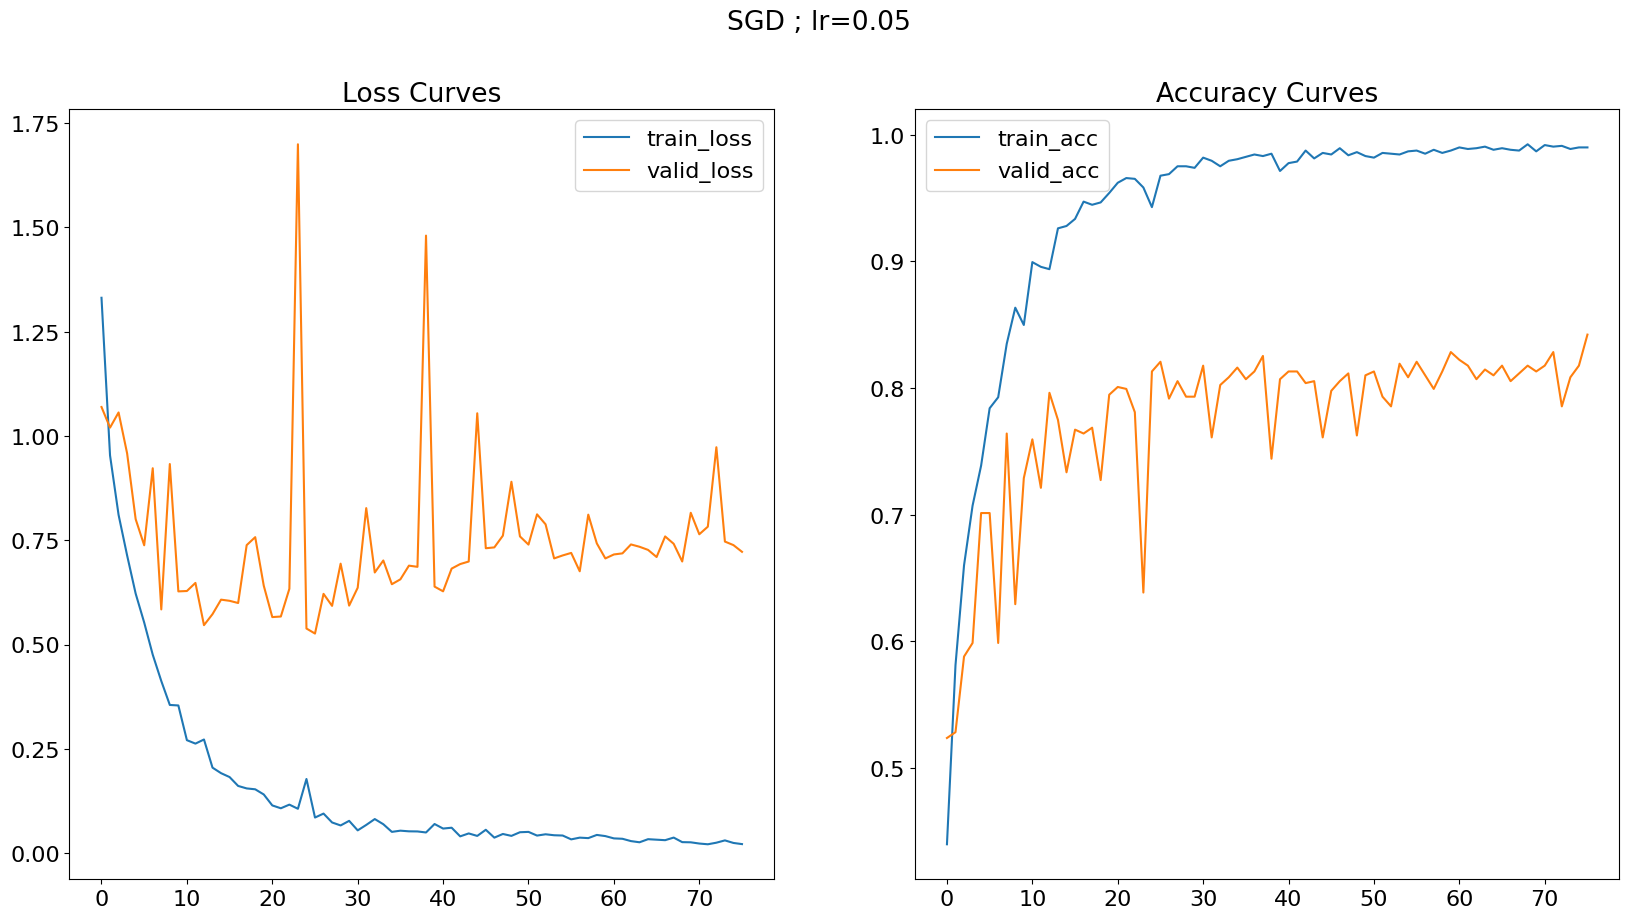

In [39]:
loss_acc_visuaize(history,optim='SGD ; lr=0.05',path='../lr=0.05')

In [40]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-sgd-lr=0.05"))

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...


<All keys matched successfully>

tensor([[ 0.1968, 51.8339,  0.8652,  0.1933]], device='cuda:0')


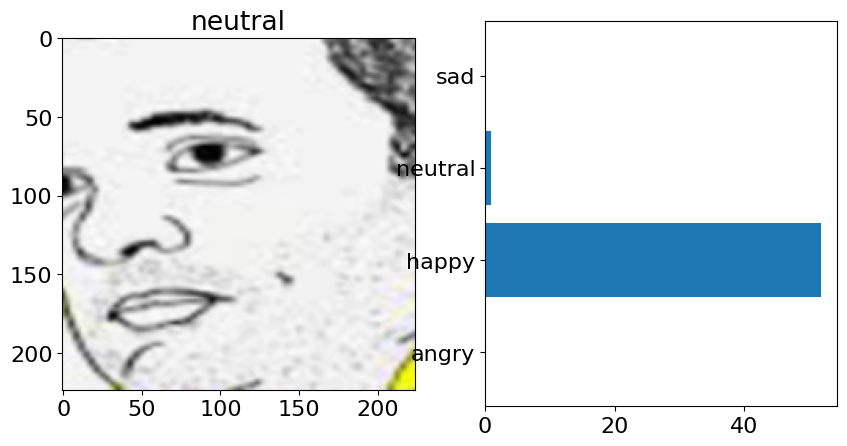

In [41]:
visual_predict(model=model)

### 5.4.3.b Accuracy using SGD with learning rate 0.05 <a class="anchor" id="h5_4_3b"></a>

In [42]:
sgd_lr05_dict = class_accuracies(model=model)

Accuracy for class sad :  0.9591836734693877
Accuracy for class neutral :  0.5
Accuracy for class angry :  0.9794520547945206
Accuracy for class happy :  0.7714285714285715


### 5.4.4 Implementing ADAM with learning rate 0.001 <a class="anchor" id="h5_4_4"></a>

Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum. 

In [43]:
vgg16 = base_model_build()
optimizer_adam = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-adam-lr=0.001'
max_epochs_stop=50
n_epochs=80
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 18.67 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.3941 	Validation Loss: 1.0142
		Training Accuracy: 41.19%	 Validation Accuracy: 53.75%
Epoch: 1	100.00% complete. 18.65 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.9216 	Validation Loss: 0.9434
		Training Accuracy: 58.87%	 Validation Accuracy: 54.06%
Epoch: 2	100.00% complete. 18.63 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.7674 	Validation Loss: 0.7425
		Training Accuracy: 66.56%	 Validation Accuracy: 63.55%
Epoch: 3	100.00% complete. 18.53 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.6227 	Validation Loss: 0.5351
		Training Accuracy: 74.94%	 Validation Accuracy: 76.57%
Epoch: 4	100.00% complete. 18.67 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.5226 	Validation Loss: 0.5516
		Training Accuracy: 80.15%	 Validation Accuracy: 76.42%
Epoch: 5	100.00% complete. 18.47 seconds elapsed in epoch.
Epoch: 5 	Training Loss:

Epoch: 47	100.00% complete. 18.39 seconds elapsed in epoch.
Epoch: 47 	Training Loss: 0.2378 	Validation Loss: 0.8799
		Training Accuracy: 95.16%	 Validation Accuracy: 81.62%
Epoch: 48	100.00% complete. 18.45 seconds elapsed in epoch.
Epoch: 48 	Training Loss: 0.1896 	Validation Loss: 0.8340
		Training Accuracy: 96.34%	 Validation Accuracy: 83.46%
Epoch: 49	100.00% complete. 18.44 seconds elapsed in epoch.
Epoch: 49 	Training Loss: 0.3132 	Validation Loss: 1.1990
		Training Accuracy: 94.98%	 Validation Accuracy: 80.25%
Epoch: 50	100.00% complete. 18.23 seconds elapsed in epoch.
Epoch: 50 	Training Loss: 0.2617 	Validation Loss: 0.8154
		Training Accuracy: 94.54%	 Validation Accuracy: 82.08%
Epoch: 51	100.00% complete. 18.42 seconds elapsed in epoch.
Epoch: 51 	Training Loss: 0.2311 	Validation Loss: 0.8028
		Training Accuracy: 95.78%	 Validation Accuracy: 82.08%
Epoch: 52	100.00% complete. 18.62 seconds elapsed in epoch.
Epoch: 52 	Training Loss: 0.2020 	Validation Loss: 0.9576
		Train

## Loss and Accuracy curve for ADAM with leaining rate 0.001 <a class="anchor" id="h5_4_4p"></a>

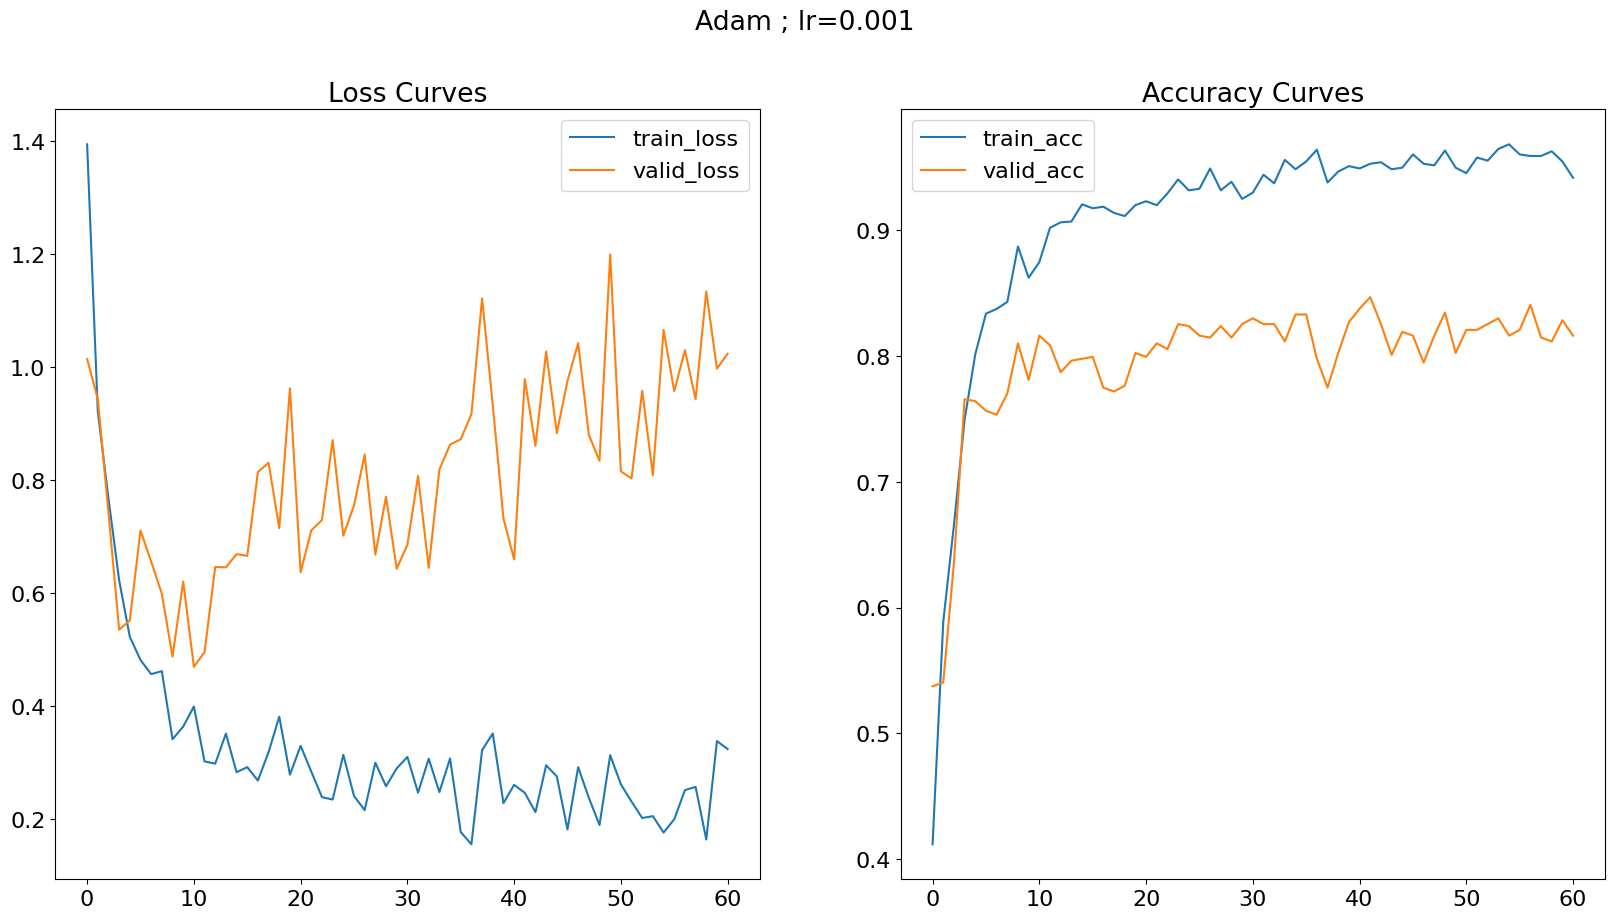

In [44]:
loss_acc_visuaize(history,optim='Adam ; lr=0.001',path='../lr=0.001')

In [45]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-adam-lr=0.001"))

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...


<All keys matched successfully>

tensor([[2.1609e-05, 9.3581e+02, 1.3319e+01, 2.4661e-04]], device='cuda:0')


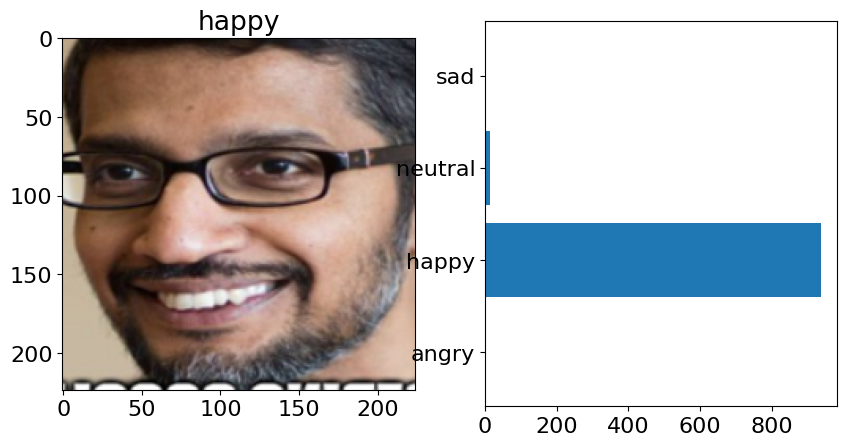

In [46]:
visual_predict(model)

### 5.4.4.b Accuracy for ADAM for with Learning Rate 0.001 <a class="anchor" id="h5_4_4b"></a>

In [47]:
adam_lr001_dict = class_accuracies(model=model)

Accuracy for class sad :  0.9591836734693877
Accuracy for class neutral :  0.66
Accuracy for class angry :  0.9383561643835616
Accuracy for class happy :  0.7095238095238096


### 5.4.5 Implementing ADAM with learning rate 0.05 <a class="anchor" id="h5_4_5"></a>

In [48]:
vgg16 = base_model_build()
optimizer_adam = optim.Adam(vgg16.classifier.parameters(), lr=0.05)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-sgd-lr=0.05'
max_epochs_stop=50
n_epochs=80
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 18.36 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 8233.9411 	Validation Loss: 130.6314
		Training Accuracy: 29.65%	 Validation Accuracy: 39.36%
Epoch: 1	100.00% complete. 18.35 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1658.3174 	Validation Loss: 5.6628
		Training Accuracy: 30.58%	 Validation Accuracy: 35.99%
Epoch: 2	100.00% complete. 18.31 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 554.3445 	Validation Loss: 2.4448
		Training Accuracy: 31.45%	 Validation Accuracy: 33.54%
Epoch: 3	100.00% complete. 18.50 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 154.8781 	Validation Loss: 1.9426
		Training Accuracy: 28.29%	 Validation Accuracy: 32.31%
Epoch: 4	100.00% complete. 18.35 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 197.9660 	Validation Loss: 1.5862
		Training Accuracy: 31.51%	 Validation Accuracy: 32.31%
Epoch: 5	100.00% complete. 18.55 seconds elapsed in epoch.
Epoch: 5 	

## Loss and Accuracy curve for ADAM with leaining rate 0.05 <a class="anchor" id="h5_4_5p"></a>

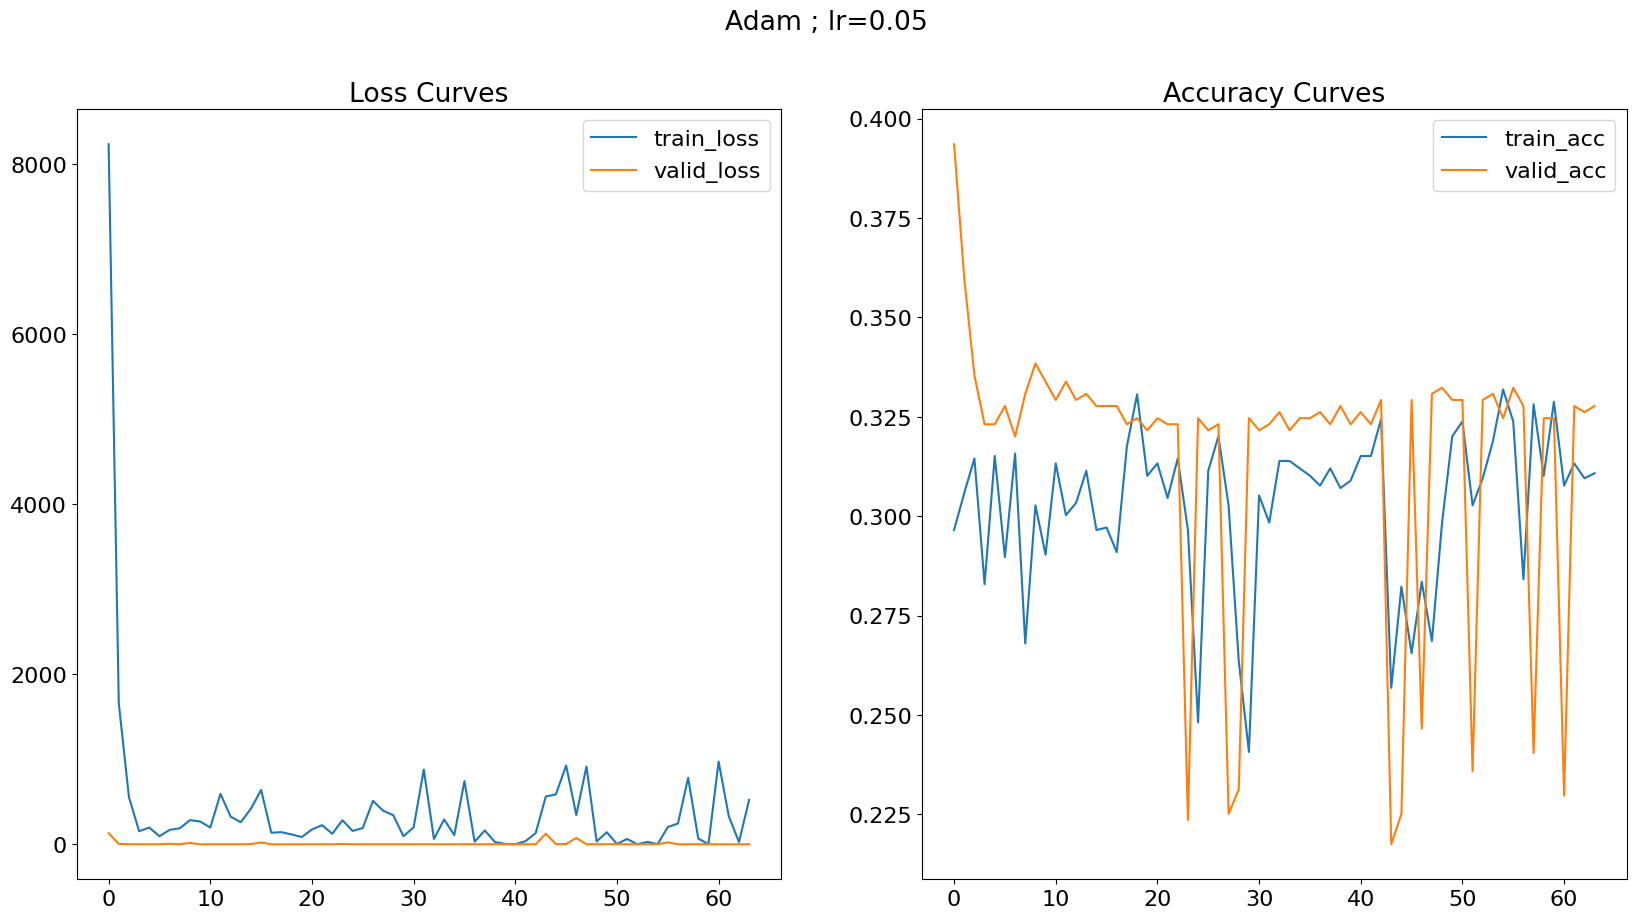

In [49]:
loss_acc_visuaize(history,optim='Adam ; lr=0.05',path='../lr=0.05')

### 5.4.6 Implementing RMSprop with learning rate 0.001 <a class="anchor" id="h5_4_6"></a>

RMSprop is a gradient-based optimization technique used in training neural networks. It was proposed by the father of back-propagation, Geoffrey Hinton. Gradients of very complex functions like neural networks have a tendency to either vanish or explode as the data propagates through the function (refer to vanishing gradients problem). Rmsprop was developed as a stochastic technique for mini-batch learning.

RMSprop deals with the above issue by using a moving average of squared gradients to normalize the gradient. This normalization balances the step size (momentum), decreasing the step for large gradients to avoid exploding and increasing the step for small gradients to avoid vanishing.
Simply put, RMSprop uses an adaptive learning rate instead of treating the learning rate as a hyperparameter. This means that the learning rate changes over time.

In [50]:
vgg16 = base_model_build()
optimizer_adam = optim.RMSprop(vgg16.classifier.parameters(), lr=0.001)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-rmsprop-lr=0.001'
max_epochs_stop=50
n_epochs=80
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 18.38 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 91.5817 	Validation Loss: 1.2981
		Training Accuracy: 31.58%	 Validation Accuracy: 42.27%
Epoch: 1	100.00% complete. 18.35 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.2476 	Validation Loss: 1.0193
		Training Accuracy: 48.70%	 Validation Accuracy: 55.28%
Epoch: 2	100.00% complete. 18.10 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.9781 	Validation Loss: 0.9841
		Training Accuracy: 59.24%	 Validation Accuracy: 59.57%
Epoch: 3	100.00% complete. 18.17 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.8335 	Validation Loss: 0.7924
		Training Accuracy: 66.13%	 Validation Accuracy: 69.37%
Epoch: 4	100.00% complete. 18.32 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.6634 	Validation Loss: 0.6399
		Training Accuracy: 74.69%	 Validation Accuracy: 71.06%
Epoch: 5	100.00% complete. 18.27 seconds elapsed in epoch.
Epoch: 5 	Training Loss

Epoch: 47	100.00% complete. 18.34 seconds elapsed in epoch.
Epoch: 47 	Training Loss: 0.2455 	Validation Loss: 0.7998
		Training Accuracy: 94.42%	 Validation Accuracy: 83.31%
Epoch: 48	100.00% complete. 18.38 seconds elapsed in epoch.
Epoch: 48 	Training Loss: 0.2034 	Validation Loss: 0.7553
		Training Accuracy: 94.91%	 Validation Accuracy: 79.94%
Epoch: 49	100.00% complete. 18.37 seconds elapsed in epoch.
Epoch: 49 	Training Loss: 0.2340 	Validation Loss: 0.5262
		Training Accuracy: 94.54%	 Validation Accuracy: 82.08%
Epoch: 50	100.00% complete. 18.45 seconds elapsed in epoch.
Epoch: 50 	Training Loss: 0.2790 	Validation Loss: 0.6387
		Training Accuracy: 94.67%	 Validation Accuracy: 80.86%
Epoch: 51	100.00% complete. 18.32 seconds elapsed in epoch.
Epoch: 51 	Training Loss: 0.2231 	Validation Loss: 0.8655
		Training Accuracy: 95.66%	 Validation Accuracy: 81.62%
Epoch: 52	100.00% complete. 18.41 seconds elapsed in epoch.
Epoch: 52 	Training Loss: 0.2575 	Validation Loss: 0.8283
		Train

## Loss and Accuracy curve for RMSprop with learning rate 0.001 <a class="anchor" id="h5_4_6p"></a>

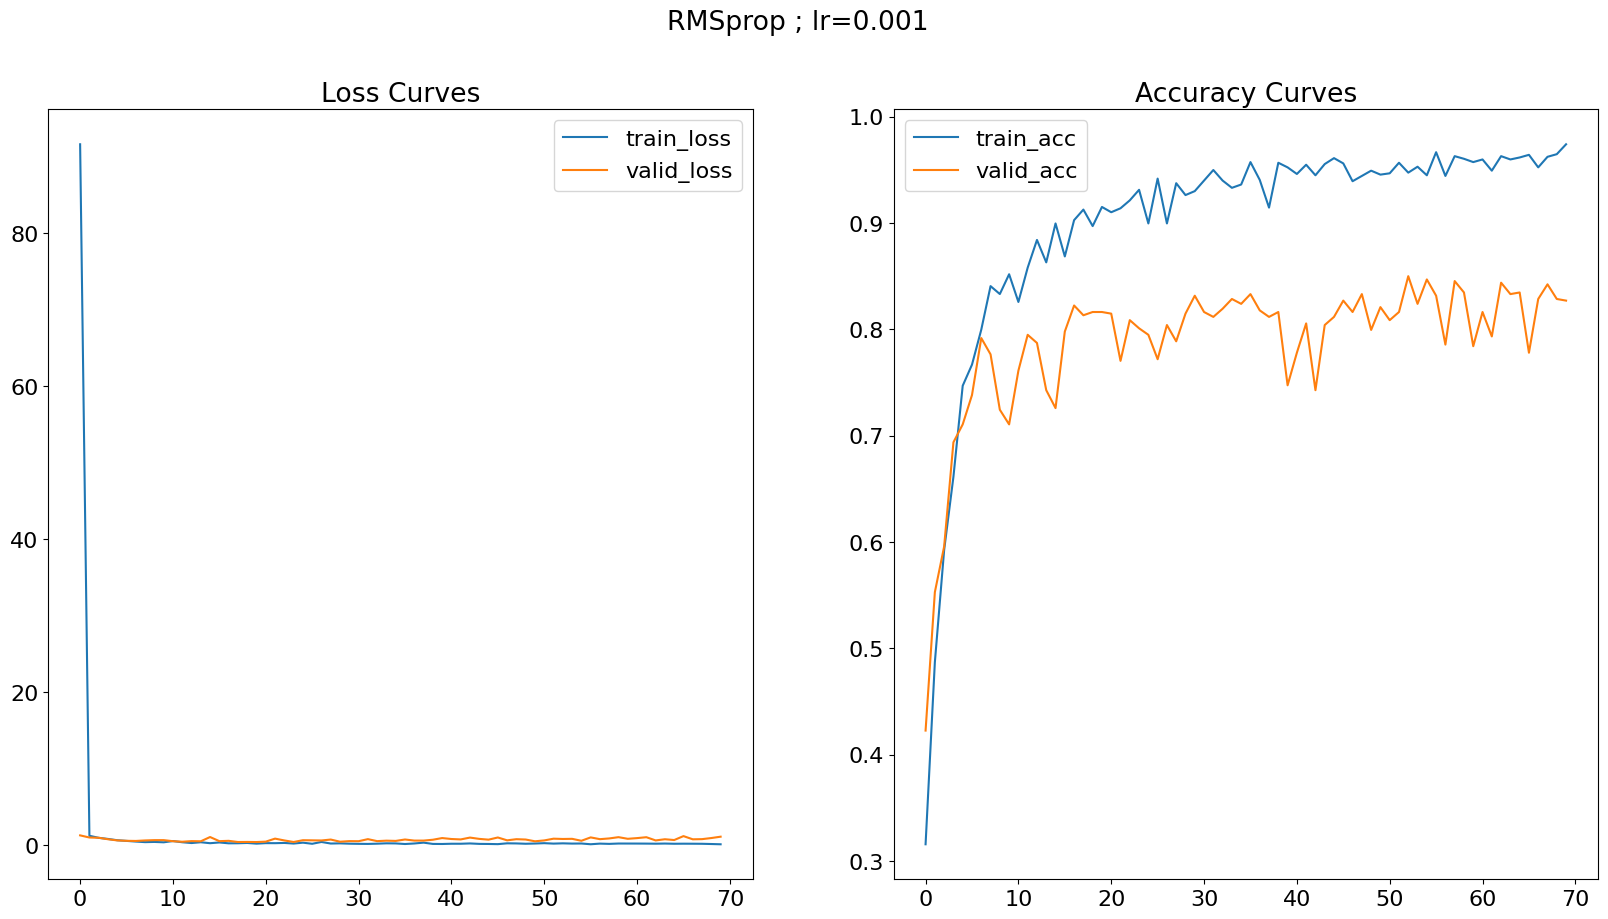

In [51]:
loss_acc_visuaize(history, optim='RMSprop ; lr=0.001',path='../lr=0.001')

In [52]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-rmsprop-lr=0.001"))

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...


<All keys matched successfully>

tensor([[8.2565e+04, 1.7693e+00, 2.3329e-01, 3.5082e+00]], device='cuda:0')


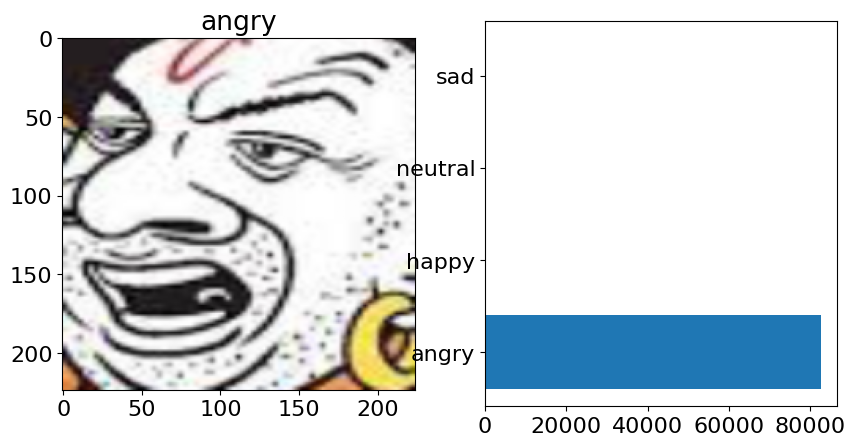

In [53]:
visual_predict(model)

In [54]:
rmsprop_lr001_dict=class_accuracies(model)

Accuracy for class sad :  0.9863945578231292
Accuracy for class neutral :  0.6466666666666666
Accuracy for class angry :  1.0
Accuracy for class happy :  0.680952380952381


### 5.4.7 Implementing RMSprop with learning rate 0.05 <a class="anchor" id="h5_4_7"></a>

In [55]:
# RMSprop with high learning rate

vgg16 = base_model_build()
optimizer_adam = optim.RMSprop(vgg16.classifier.parameters(), lr=0.05)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-sgd-1'
max_epochs_stop=50
n_epochs=80
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 18.32 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 6183386.4464 	Validation Loss: 9496.4943
		Training Accuracy: 30.15%	 Validation Accuracy: 45.18%
Epoch: 1	100.00% complete. 18.18 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 20461.0113 	Validation Loss: 6277.5179
		Training Accuracy: 33.19%	 Validation Accuracy: 31.70%
Epoch: 2	100.00% complete. 18.17 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 4620.5178 	Validation Loss: 12.6975
		Training Accuracy: 35.55%	 Validation Accuracy: 33.69%
Epoch: 3	100.00% complete. 18.10 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 4399.3553 	Validation Loss: 3.6037
		Training Accuracy: 34.49%	 Validation Accuracy: 34.61%
Epoch: 4	100.00% complete. 18.81 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 937.1876 	Validation Loss: 4.6575
		Training Accuracy: 35.92%	 Validation Accuracy: 33.23%
Epoch: 5	100.00% complete. 18.70 seconds elapsed in epoch.

## Loss and Accuracy plot for RMSprop with learning rate 0.05 <a class="anchor" id="h5_4_7"></a>

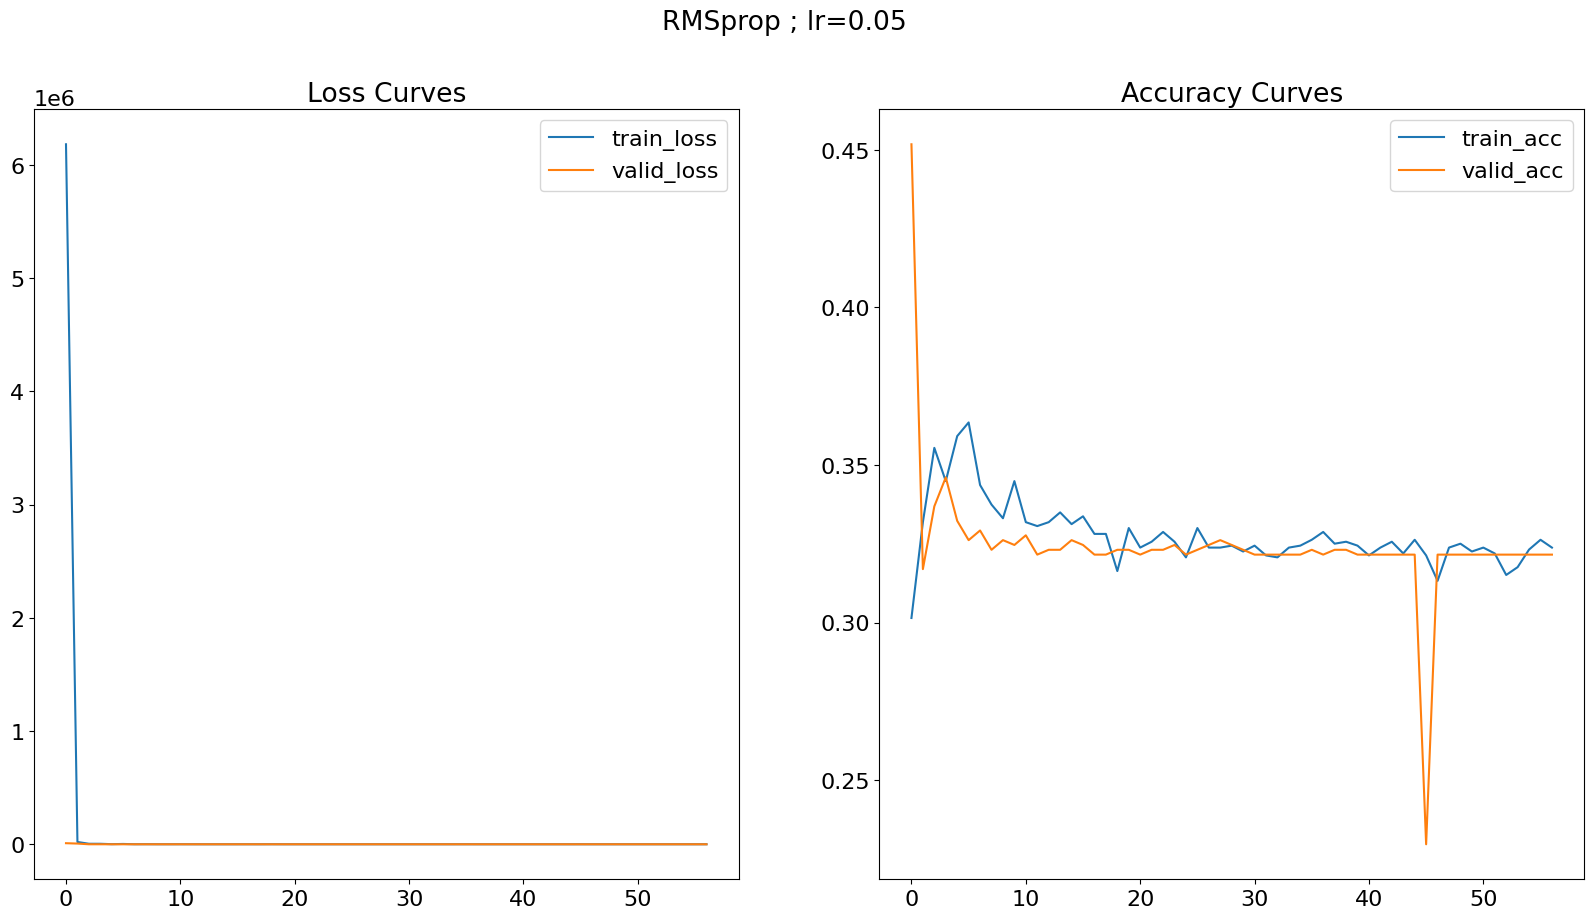

In [56]:
loss_acc_visuaize(history, optim='RMSprop ; lr=0.05',path='../lr=0.05')

In [57]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-sgd-1"))

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...


<All keys matched successfully>

tensor([[1.3454, 1.7369, 1.2096, 1.2670]], device='cuda:0')


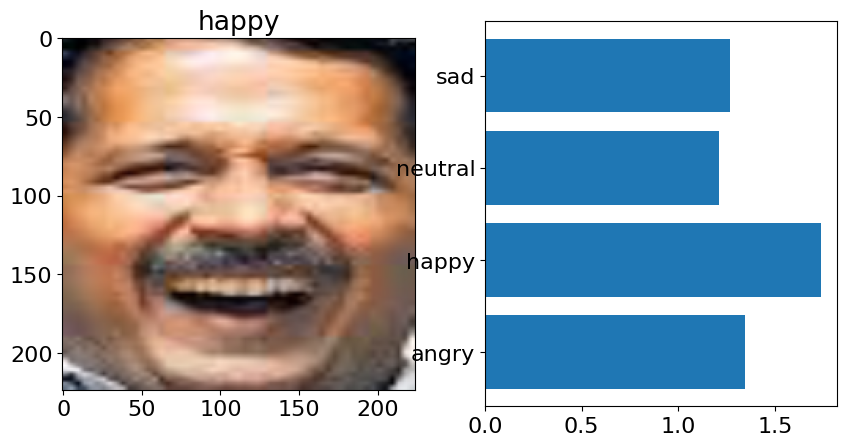

In [58]:
visual_predict(model)

### 5.4.6.b  Accuracy for RMSprop with learning rate 0.05 <a class="anchor" id="h5_4_6b"></a>

In [59]:
_=class_accuracies(model)

Accuracy for class sad :  0.0
Accuracy for class neutral :  0.0
Accuracy for class angry :  0.00684931506849315
Accuracy for class happy :  1.0


### 5.4.7 Implementing Adagrad with learning rate 0.001 <a class="anchor" id="h5_4_7"></a>

Adaptive Gradient Algorithm (Adagrad) is an algorithm for gradient-based optimization. The learning rate is adapted component-wise to the parameters by incorporating knowledge of past observations.  It performs larger updates (e.g. high learning rates) for those parameters that are related to infrequent features and smaller updates (i.e. low learning rates) for frequent one. It performs smaller updates As a result, it is well-suited when dealing with sparse data (NLP or image recognition) Each parameter has its own learning rate that improves performance on problems with sparse gradients.

In [60]:
vgg16 = base_model_build()
optimizer_adam = optim.Adagrad(vgg16.classifier.parameters(), lr=0.001)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-adagrad-lr=0.001'
max_epochs_stop=50
n_epochs=80
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 18.05 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.3743 	Validation Loss: 1.0481
		Training Accuracy: 39.76%	 Validation Accuracy: 51.15%
Epoch: 1	100.00% complete. 18.10 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.9183 	Validation Loss: 0.9932
		Training Accuracy: 58.37%	 Validation Accuracy: 57.58%
Epoch: 2	100.00% complete. 18.35 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.7336 	Validation Loss: 0.8921
		Training Accuracy: 68.92%	 Validation Accuracy: 60.03%
Epoch: 3	100.00% complete. 18.01 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.5960 	Validation Loss: 0.6746
		Training Accuracy: 74.88%	 Validation Accuracy: 71.36%
Epoch: 4	100.00% complete. 18.13 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.4994 	Validation Loss: 0.8250
		Training Accuracy: 80.77%	 Validation Accuracy: 71.52%
Epoch: 5	100.00% complete. 18.04 seconds elapsed in epoch.
Epoch: 5 	Training Loss:

Epoch: 47	100.00% complete. 18.12 seconds elapsed in epoch.
Epoch: 47 	Training Loss: 0.0300 	Validation Loss: 0.6581
		Training Accuracy: 99.13%	 Validation Accuracy: 81.93%
Epoch: 48	100.00% complete. 18.16 seconds elapsed in epoch.
Epoch: 48 	Training Loss: 0.0216 	Validation Loss: 0.6367
		Training Accuracy: 99.32%	 Validation Accuracy: 82.24%
Epoch: 49	100.00% complete. 18.10 seconds elapsed in epoch.
Epoch: 49 	Training Loss: 0.0306 	Validation Loss: 0.6492
		Training Accuracy: 98.95%	 Validation Accuracy: 81.78%
Epoch: 50	100.00% complete. 17.84 seconds elapsed in epoch.
Epoch: 50 	Training Loss: 0.0241 	Validation Loss: 0.7484
		Training Accuracy: 99.01%	 Validation Accuracy: 80.86%
Epoch: 51	100.00% complete. 18.11 seconds elapsed in epoch.
Epoch: 51 	Training Loss: 0.0271 	Validation Loss: 0.7931
		Training Accuracy: 99.07%	 Validation Accuracy: 79.63%
Epoch: 52	100.00% complete. 18.11 seconds elapsed in epoch.
Epoch: 52 	Training Loss: 0.0333 	Validation Loss: 0.6615
		Train

## Loss and Accuracy curve for AdaGrad with loss 0.001 <a class="anchor" id="h5_4_7p"></a>

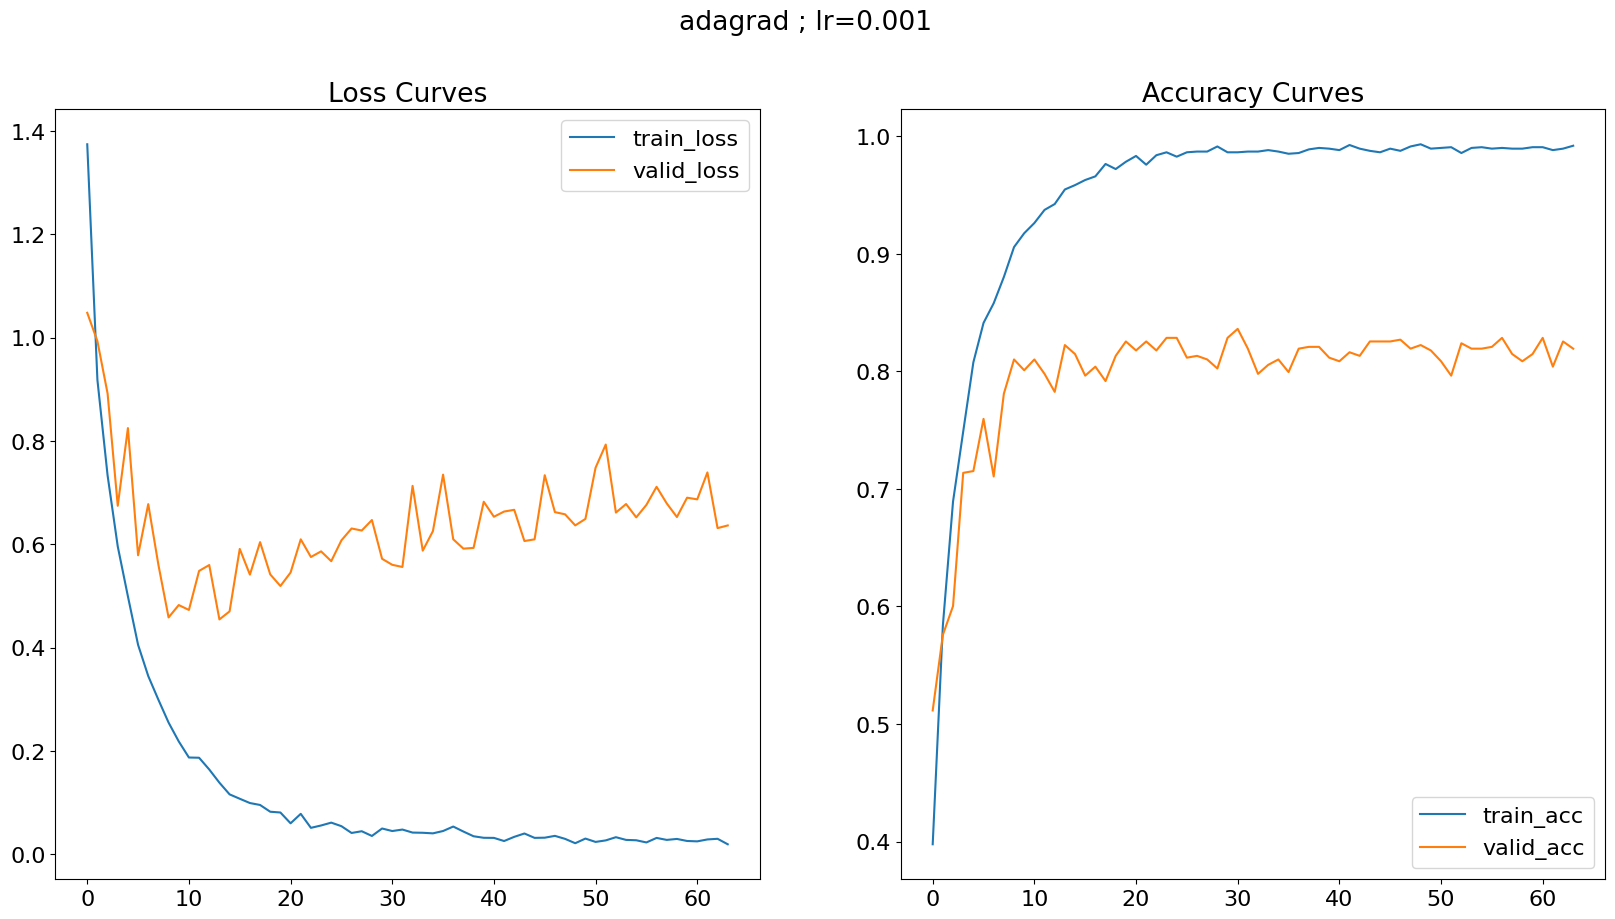

In [61]:
loss_acc_visuaize(history,optim="adagrad ; lr=0.001",path="../lr=0.001")

In [62]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-adagrad-lr=0.001"))

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...


<All keys matched successfully>

tensor([[1.5618e+02, 3.5765e-01, 1.9053e-02, 9.1405e-02]], device='cuda:0')


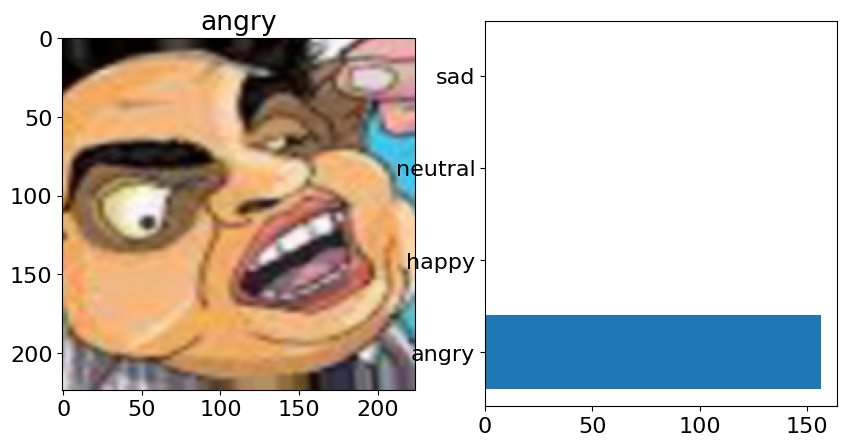

In [63]:
visual_predict(model)

### 5.4.7.b Accuracy for AdaGrad with Learning Rate 0.001 <a class="anchor" id="h5_4_7b"></a>

In [64]:
adagrad_dict_lr001=class_accuracies(model)

Accuracy for class sad :  0.9251700680272109
Accuracy for class neutral :  0.5933333333333334
Accuracy for class angry :  0.9726027397260274
Accuracy for class happy :  0.7904761904761904


### 5.4.8 Implementing Adagrad with learning rate 0.05 <a class="anchor" id="h5_4_8"></a>

In [65]:
# adagrad ; high learning rate

vgg16 = base_model_build()
optimizer_adam = optim.Adagrad(vgg16.classifier.parameters(), lr=0.05)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-adagrad-lr=0.05'
max_epochs_stop=50
n_epochs=80
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 18.01 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 7785.0530 	Validation Loss: 11.4141
		Training Accuracy: 28.66%	 Validation Accuracy: 37.21%
Epoch: 1	100.00% complete. 17.98 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 37.0854 	Validation Loss: 4.7137
		Training Accuracy: 35.36%	 Validation Accuracy: 38.28%
Epoch: 2	100.00% complete. 17.94 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 17.3296 	Validation Loss: 2.6701
		Training Accuracy: 42.18%	 Validation Accuracy: 45.64%
Epoch: 3	100.00% complete. 18.25 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 7.8525 	Validation Loss: 1.1539
		Training Accuracy: 46.34%	 Validation Accuracy: 56.36%
Epoch: 4	100.00% complete. 18.33 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 7.7260 	Validation Loss: 1.1654
		Training Accuracy: 45.84%	 Validation Accuracy: 48.85%
Epoch: 5	100.00% complete. 18.07 seconds elapsed in epoch.
Epoch: 5 	Training

Epoch: 47	100.00% complete. 17.72 seconds elapsed in epoch.
Epoch: 47 	Training Loss: 0.6852 	Validation Loss: 0.7413
		Training Accuracy: 71.84%	 Validation Accuracy: 72.89%
Epoch: 48	100.00% complete. 17.80 seconds elapsed in epoch.
Epoch: 48 	Training Loss: 0.7219 	Validation Loss: 0.6781
		Training Accuracy: 71.34%	 Validation Accuracy: 73.20%
Epoch: 49	100.00% complete. 17.86 seconds elapsed in epoch.
Epoch: 49 	Training Loss: 0.7933 	Validation Loss: 0.7001
		Training Accuracy: 70.22%	 Validation Accuracy: 71.52%
Epoch: 50	100.00% complete. 17.82 seconds elapsed in epoch.
Epoch: 50 	Training Loss: 0.7468 	Validation Loss: 0.7571
		Training Accuracy: 71.84%	 Validation Accuracy: 71.67%
Epoch: 51	100.00% complete. 17.76 seconds elapsed in epoch.
Epoch: 51 	Training Loss: 0.6580 	Validation Loss: 0.6632
		Training Accuracy: 72.89%	 Validation Accuracy: 73.81%
Epoch: 52	100.00% complete. 17.90 seconds elapsed in epoch.
Epoch: 52 	Training Loss: 0.7146 	Validation Loss: 0.6950
		Train

## Loss and Accuracy Curve for AdaGrad with learning rate 0.05 <a class="anchor" id="h5_4_8p"></a>

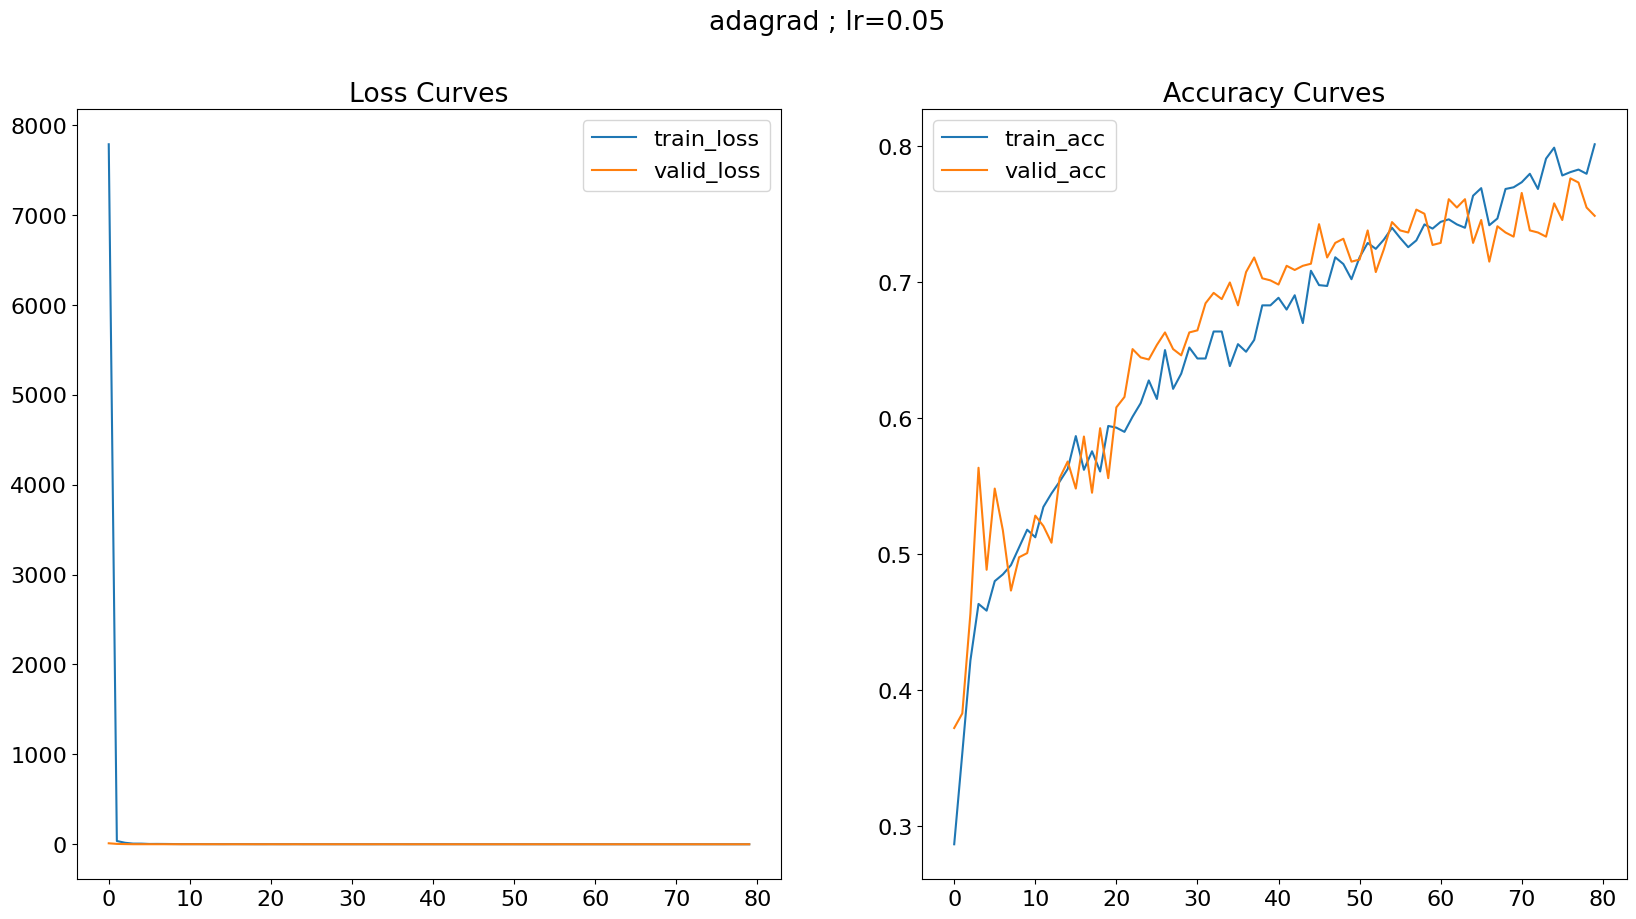

In [66]:
loss_acc_visuaize(history,optim="adagrad ; lr=0.05", path="../lr=0.05")

In [67]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-adagrad-lr=0.05"))

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...


<All keys matched successfully>

tensor([[2.3503e-01, 1.8161e+04, 2.7614e+03, 1.6736e+00]], device='cuda:0')


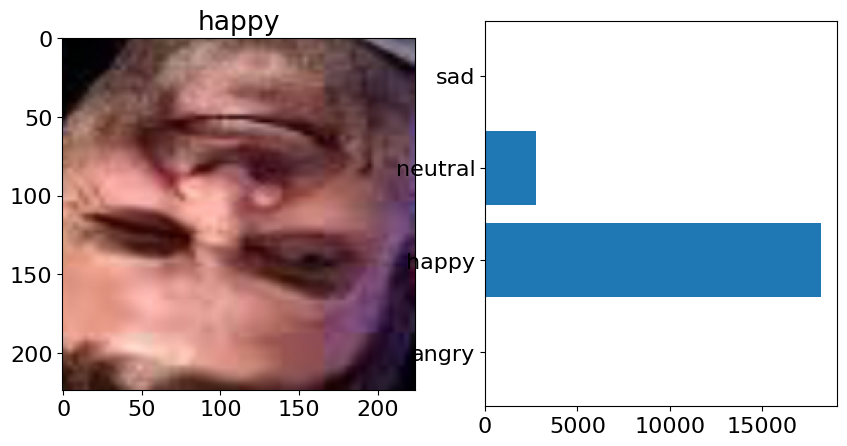

In [68]:
visual_predict(model)

### 5.4.8.b Accuracy for adagrad with learning rate 0.05 <a class="anchor" id="h5_4_8p"></a>

In [69]:
adagrad_dict_lr05=class_accuracies(model)

Accuracy for class sad :  0.9115646258503401
Accuracy for class neutral :  0.72
Accuracy for class angry :  0.9657534246575342
Accuracy for class happy :  0.5857142857142857


# 6. Report

## 6.1 Accuracies of different optimizers for different classes

In [70]:
optims = ['sgd_lr001','sgd_lr05','adam_lr001','rmsprop_lr001','adagrad_lr001','adagrad_lr05']
classcounts = {}
for c in classes:
    classcounts[str(c)] = [sgd_lr001_dict[str(c)],sgd_lr05_dict[str(c)],adam_lr001_dict[str(c)],rmsprop_lr001_dict[str(c)],adagrad_dict_lr001[str(c)],adagrad_dict_lr05[str(c)]]

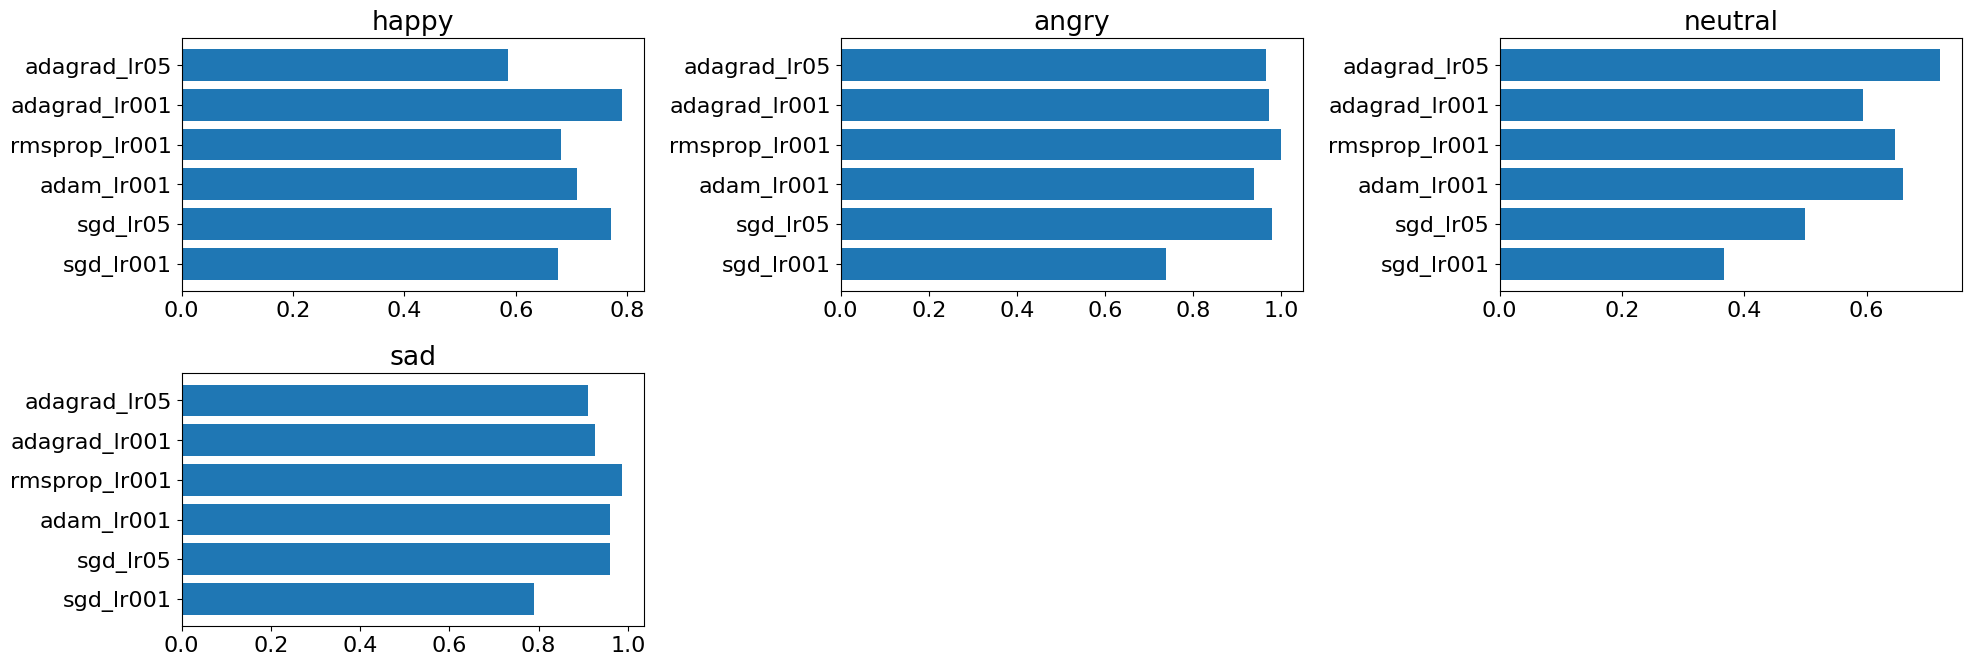

In [72]:
plt.figure(figsize=(20,10))

plt.subplot(331)
plt.barh(optims,classcounts['happy'])
plt.title('happy')

plt.subplot(332)
plt.barh(optims,classcounts['angry'])
plt.title('angry')

plt.subplot(333)
plt.barh(optims,classcounts['neutral'])
plt.title('neutral')

plt.subplot(334)
plt.barh(optims,classcounts['sad'])
plt.title('sad')


plt.tight_layout()

# So adam with lr 0.001 gives the most consistant results

In [6]:
# Testing Path
test_path = '/home/sysadm/Desktop/Ujjwal/archive/brain_dead_emotion_detection/Test/'

classes = ["sad", "happy", "neutral", "angry"]

# Counting the number of images inside each classes
def data_count(path):
    counts = {}
    for root,dirs,files in os.walk(path):
        if files != [] and str(root.split('/')[-1]) in classes:
            counts[str(root.split('/')[-1])] = len(files)
    return counts

counts = data_count(test_path)

# Creating a list for the training data
test_dict = {}
counts = data_count(test_path)

for root,dirs,files in os.walk(test_path):
        if files != [] and str(root.split('/')[-1]) in classes:
            file_paths = [os.path.join(root,files[i]) for i in range(len(files))]
            test_idxs = np.random.randint(low=0,high=len(files),size=int(len(files)))           
            test_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in test_idxs]
            
###
data_test = RIData(test_dict)

In [31]:

# Path for the training data
path = '/home/sysadm/Desktop/Ujjwal/whole_all/'

classes = ['angry', 'happy', 'neutral', 'sad']

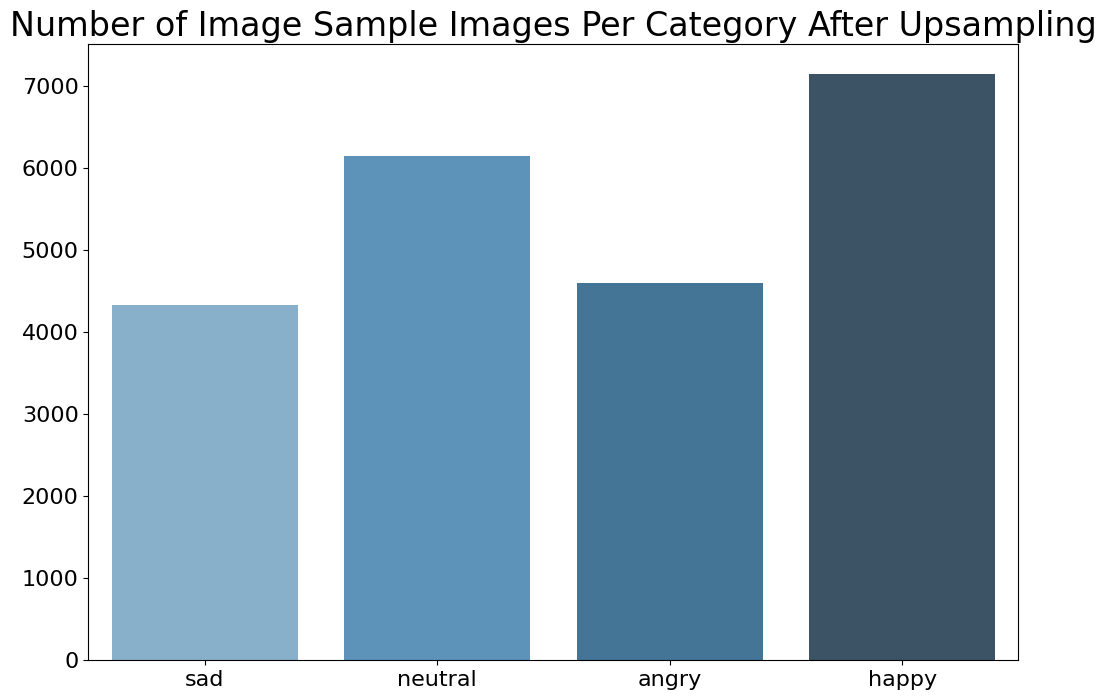

In [33]:
# Creating a function to count the number of files inside each folders of the directory
def data_count(path):
    counts = {}
    for root,dirs,files in os.walk(path):
        if files != [] and str(root.split('/')[-1]) in classes:
            counts[str(root.split('/')[-1])] = len(files)
    return counts

counts = data_count(path)


# Plot number of files per category
plt.figure(figsize=(12,8))

plt.title('Number of Image Sample Images Per Category After Upsampling', 
          fontsize=24)

sns.barplot(x = list(counts.keys()),
            y = list(counts.values()) , 
            palette="Blues_d" )

plt.show()

In [8]:
def data_split(path, split_percentage = 0.3):
    train_dict = {} # Dictionary to store training data
    valid_dict = {} # Dictionary to store validation data
    counts = data_count(path)
    for root,dirs,files in os.walk(path):
        if files != [] and str(root.split('/')[-1]) in classes:
            file_paths = [os.path.join(root,files[i]) for i in range(len(files))]
            
            valid_idxs = np.random.randint(low=0,high=len(files),size=int(len(files)*split_percentage))
            train_idxs = list(set(range(0,len(files))) - set(valid_idxs))
            
            train_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in train_idxs]
            valid_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in valid_idxs]
            
    return train_dict, valid_dict

train_dict, valid_dict = data_split(path) 

In [9]:
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ColorJitter(),
                                     transforms.Resize((224,224))])

data_train = RIData(train_dict,transform = data_transform)
data_valid = RIData(valid_dict,transform = data_transform)

In [10]:
train_loader = DataLoader(data_train, batch_size=50, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=50, shuffle=True)

In [11]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched[0].size(),sample_batched[1])
    print(type(sample_batched[0]))
    break

0 torch.Size([50, 3, 224, 224]) tensor([2, 0, 1, 1, 2, 3, 1, 0, 1, 0, 2, 2, 0, 3, 3, 1, 0, 3, 0, 3, 1, 2, 2, 0,
        2, 1, 3, 3, 3, 3, 1, 0, 2, 1, 2, 3, 3, 1, 0, 1, 2, 2, 3, 2, 3, 2, 2, 0,
        3, 0])
<class 'torch.Tensor'>


In [22]:
criterion = nn.CrossEntropyLoss()

vgg16 = base_model_build()
optimizer_adam = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-adam-lr=0.001'
max_epochs_stop=50
n_epochs=80
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 174.30 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.0898 	Validation Loss: 0.9797
		Training Accuracy: 50.31%	 Validation Accuracy: 52.99%
Epoch: 1	100.00% complete. 173.51 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.9315 	Validation Loss: 0.7563
		Training Accuracy: 59.12%	 Validation Accuracy: 65.44%
Epoch: 2	100.00% complete. 174.20 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.8527 	Validation Loss: 0.7528
		Training Accuracy: 62.47%	 Validation Accuracy: 67.06%
Epoch: 3	100.00% complete. 172.82 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.8098 	Validation Loss: 0.7212
		Training Accuracy: 65.02%	 Validation Accuracy: 67.90%
Epoch: 4	100.00% complete. 169.92 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.7548 	Validation Loss: 0.7029
		Training Accuracy: 67.08%	 Validation Accuracy: 68.60%
Epoch: 5	100.00% complete. 170.38 seconds elapsed in epoch.
Epoch: 5 	Training

Epoch: 47	100.00% complete. 171.21 seconds elapsed in epoch.
Epoch: 47 	Training Loss: 0.3449 	Validation Loss: 0.7787
		Training Accuracy: 87.37%	 Validation Accuracy: 74.98%
Epoch: 48	100.00% complete. 169.07 seconds elapsed in epoch.
Epoch: 48 	Training Loss: 0.3384 	Validation Loss: 0.7711
		Training Accuracy: 87.75%	 Validation Accuracy: 74.59%
Epoch: 49	100.00% complete. 170.05 seconds elapsed in epoch.
Epoch: 49 	Training Loss: 0.3263 	Validation Loss: 0.8020
		Training Accuracy: 88.02%	 Validation Accuracy: 75.17%
Epoch: 50	100.00% complete. 169.52 seconds elapsed in epoch.
Epoch: 50 	Training Loss: 0.3376 	Validation Loss: 0.7983
		Training Accuracy: 88.01%	 Validation Accuracy: 74.84%
Epoch: 51	100.00% complete. 170.36 seconds elapsed in epoch.
Epoch: 51 	Training Loss: 0.3223 	Validation Loss: 0.7608
		Training Accuracy: 88.44%	 Validation Accuracy: 75.10%
Epoch: 52	100.00% complete. 170.10 seconds elapsed in epoch.
Epoch: 52 	Training Loss: 0.3218 	Validation Loss: 0.7564
	

In [24]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-adam-lr=0.001"))

/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sysadm/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on gpu...


<All keys matched successfully>

In [25]:
adam_lr001_dict = class_accuracies(model=model)

Accuracy for class sad :  0.5431432973805855
Accuracy for class neutral :  0.7631436314363144
Accuracy for class angry :  0.7445573294629898
Accuracy for class happy :  0.8237762237762237


In [ ]:
# Lets see the results for the test data

In [46]:
def visual_predict_(model,data=data_test):
    c = np.random.randint(0,len(data))
    img, label = data[c]

    with torch.no_grad():
            model.eval()
            # Model outputs log probabilities
            out = model(img.view(1,3,224,224).cuda())
            out = torch.exp(out)
            print(out)

    plt.figure(figsize = (10,5))
    plt.subplot(121)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.title(str(classes[label]))
    plt.subplot(122)
    plt.barh(classes,out.cpu().numpy()[0])

    plt.show()
    

    
    
    
def class_accuracies_(model,data_dict=test_dict,classes=classes):
    accuracy_dict = {}
    #correct_dict ={}
    #total_dict = {}
    act_classes = []
    pred_classed = []
    with torch.no_grad():
        model.eval()
        for c in data_dict.keys():
            correct_count = 0
            total_count = len(data_dict[str(c)])
            gt = classes.index(str(c))
            for path in data_dict[str(c)]:
                #print(path)
                im = Image.open(path).convert('RGB')
                #im.show()
                im = transforms.ToTensor()(im)
                im = transforms.Resize((224,224))(im)
                out = model(im.view(1,3,224,224).cuda())
                #print(out)
                out = torch.exp(out)
                pred = list(out.cpu().numpy()[0])
                #print(pred)
                pred = pred.index(max(pred))
                #print(pred,gt)
                pred_classed.append(pred)
                act_classes.append(gt)

                if gt == pred:
                    correct_count += 1
            print(f"Accuracy for class {str(c)} : ",correct_count/total_count)
            accuracy_dict[str(c)] = correct_count/total_count
            
    return accuracy_dict, act_classes,pred_classed 
    

In [47]:
results_dicts,actual_class,pred_class = class_accuracies_(model=model)

Accuracy for class sad :  1.0
Accuracy for class neutral :  0.8725490196078431
Accuracy for class angry :  0.9375
Accuracy for class happy :  0.8666666666666667


In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix(actual_class, pred_class)

array([[75,  1,  2,  2],
       [ 0, 91, 14,  0],
       [ 2,  9, 89,  2],
       [ 0,  0,  0, 82]])

In [52]:
from sklearn.metrics import classification_report

In [54]:
print(classification_report(actual_class, pred_class))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96        80
           1       0.90      0.87      0.88       105
           2       0.85      0.87      0.86       102
           3       0.95      1.00      0.98        82

    accuracy                           0.91       369
   macro avg       0.92      0.92      0.92       369
weighted avg       0.91      0.91      0.91       369

